# Final Project Part 3 

### William Hinkley 

## Project Topic: What Best Predicts Ski Resort Ticket Prices? 

Skiing is an essential pastime to many Colorado natives such as myself. However, the ability to ski or ride the slopes is extremely cost-prohibitive, and lift ticket prices continue to rise year by year. Various ski resorts appear to share many similar features to the casual skier, yet some resort ticket prices are much higher than others. Are there clear reasons for why some resorts are priced through the roof, or are some ski resort owners overpricing their lift tickets and not offering more/better features for what skiers are paying? 

In this project, I will attempt to build the best regression model possible to predict adult lift ticket prices for ski resorts. I will try to predict adult ticket prices based on different objective and subjective features of these ski resorts. Examples of objective features might be total size or total area available for freeriding (in kilometers), while examples of subjective features might be ratings of overall cleanliness or accomodations, out of five. Using combinations and/or amalgamations of predictors like those mentioned above, I will attempt to find the best predictor of adult lift ticket prices (at least for resorts in the USA, and possible other countries), and then conclude whether or not the resorts with the best feature or combinations of features are charging more for lift tickets. 

## Data Description

The aforementioned measurements and ratings come from a single dataset, which was derived from data retrieved from www.skiresort.info, a leading information portal offering data, knowledge, and ratings from experts on 6100 world ski resorts. According to their own website, this is the world's largest rating portal and ski resort knowledge pool, with 16.4 million unique users visiting the site per year. The specific dataset that will be used for this model was compiled by a kaggle user and made public - URLs to the pages that were used in data collection are included with the data, so accuracy may be verified.  

Citation: 

De Frutos, M. (n.d.). Ski Resorts World Wide [Dataset]. https://www.kaggle.com/datasets/migueldefrutos/ski-resorts-world-wide

In the code block below, the dataset is read into pandas and described. The data contains 5478 entries/ski resorts, and 33 descriptive features. The size of the file is approximately 1.4 megabytes. The data type of each feature is listed. The dataset is tabulated into a single table. 

In [1]:
#Importation of any needed libraries done here 
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split

In [2]:
skidata = pd.read_csv('resortworldwide.csv')
skidata.columns = skidata.columns.str.strip()
skidata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 33 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   URL                                                         5478 non-null   object 
 1   Rate                                                        3471 non-null   float64
 2   NameResort                                                  5478 non-null   object 
 3   Stars                                                       413 non-null    float64
 4   Km Freeride                                                 480 non-null    float64
 5   Continent                                                   5469 non-null   object 
 6   Country                                                     5469 non-null   object 
 7   State/Province                                              5469 non-null   object 
 8 

Many of the attributes described above have self-explanatory titles. 

Some attributes which may be confusing have been described by the compiler of the dataset on Kaggle. I will list some here, along with explanations of what the attributes mean or represent. All attributes from rows 14-28 in the table above are given as ratings out of five ($\textit{with a rating of one being the lowest value}$), and any further confusion can hopefully be resolved by incorporating this fact (EX: the Beginners attribute can be interpreted as how friendly a particular resort is to Beginner skiers, out of five): 
- URL: The internet link to the website from which the data was gathered for a particular ski resort/row
- Rate: The overall rating out of five given to a particular resort from skiresort.info
- Stars: The star rating out of five given to a particular resort (I am not sure how/why this is given alongside an overall rating - I will not be including this attribute into my model)
- $\textbf{NOTE***}$: Any measurement offered in Kms is reported in kilometers - ski resorts, particularly those in Europe, measure their ski resorts by the total length of runs offered, not area. For example, Km Freeride measures the total length of freeride, or ungroomed runs in a ski resort. Also, the $\textbf{Altitude}$ column is given in meters.  
- Easy, Intermediate, and Difficult: All measures of the number of runs in km of each difficulty. 
- Adult - the price of one adult lift ticket, in whichever currency reported in the corresponding currency column. $\textbf{The Adult column will be the dependent variable in our linear regression models}$
- Apres-ski: the rating of after-sking activities available, out of five
- There is a category for Ski resort size, which is a rating out of five, and total kms, which is a measurement of the total length of runs in a ski resort. I am not entirely sure why a rating of size was included or what it means - perhaps how big a ski resort "feels"? In any case, it may be confusing to include both of these measurements - I will only factor in Total Kms into my model. 
- There is a "Country" attribute and a "country" attribute, the latter of which gives a two-letter code for the country that is spelled out entirely by the former. I am not sure why both were included, but neither should be particularly relevant to my model, since the primary factor by which I will separate data is via Currency. 

## Data Cleaning 

Glancing at the data, we can see that every adult lift ticket price (the "Adult" column), has a corresponding currency type (except for the entries marked as "0", but these will not be factored in). For example, any resort in the USA has a lift ticket price in US Dollars, while many resorts in Europe have prices in European Euros. The code block below shows every different currency value present in the dataset: 

In [3]:
skidata["Currency"].value_counts()

-                          1952
European Euro              1473
US Dollar                   435
Japanese Yen                316
Swiss Franc                 284
Czech koruna                231
Canadian Dollar             197
Polish zloty                125
Norwegian krone             105
Swedish krona                95
UK Pound                     49
New Zealand Dollar           24
Romanian leu                 21
Chiliean Peso                16
Russian ruble                14
Argentine Peso               13
Chinese Yuan                 12
Bosnia convertible mark      11
Icelandic krona              10
Australian dollar            10
Hungarian forint              9
South Korean won              8
Ukrainian hryvnia             7
Bulgarian Lev                 6
Turkish lira                  6
Danish Krone                  5
Lebanese pound                4
Croatian Kuna                 4
Georgian Lari                 4
Serbian dinar                 4
South African rand            3
Kyrgyzst

We can see that most of the currencies have only a few entries, and are not worth exploring. It is worth exploring all resorts with ticket prices in US Dollars, since this is the country in which I reside and the results of the model will resonate most with me. It will also be worthwhile to analyze all resorts with lift ticket prices in European Euros, since this is the currency with the most data.

It should be noted that, while it would be possible to convert from one currency value to another in order to predict a price in one single currency, I believe there are enough regional differences between areas that accept different kinds of currency to justify separate models. Factors such as currency fluctuation, consumer preferences with different types of currency, particular customs or offerings of ski resorts in different geographical areas, and many others could cause significant differences in the measurements of certain attributes of ski resorts amongst areas that accept different types of currency. I would like to minimize such differences and group data in a sensible way. Additionally, the amount of data on resorts that accept Euros is over three times that of resorts that accept the US dollar, the next closest currency by number of resorts measured. So, including all of the data in one model with currency conversions doesn't quite make sense (if I were only to group the Euro and the US dollar ski resorts together), since all resorts that accept dollars would be eclipsed by the resorts that accept Euros, which likely would generate a problematic model. Converting every type of currency to US dollars or Euros would be time consuming and not worth the effort for most of the currencies listed above, which only contain a handful of entries. Overall, calculations and predictions are much simplified by only analyzing resorts that accept Euros and US Dollars, separately.

### Cleaning and EDA - US Data

The following code block creates a new dataframe and visualizes the data for all resorts that charge lift ticket prices in US dollars: 

In [4]:
usdols = skidata.loc[skidata['Currency'] == "US Dollar"]

usdols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 3517 to 5273
Data columns (total 33 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   URL                                                         435 non-null    object 
 1   Rate                                                        308 non-null    float64
 2   NameResort                                                  435 non-null    object 
 3   Stars                                                       0 non-null      float64
 4   Km Freeride                                                 20 non-null     float64
 5   Continent                                                   435 non-null    object 
 6   Country                                                     435 non-null    object 
 7   State/Province                                              435 non-null    object 
 

The data for the resorts accepting US dollars is described above. Unfortunately, many of these features simply do not contain enough entries, or close to enough entries, to incorporate into a model. Fortunately, there are a number of features that can still be used to build our model. We can ignore features that are not particularly interesting (URL, Continent, Country, etc). Features that may be of interest and have the required amount of data to include in our regression are as follows: 

- Altitude
- Easy, Intermediate, and Difficult (the overall number of kilometers of each type of run in the resort)
- Total Kms (the size of the resort in kilometers)

The code block below creates a new usdols_c dataframe that only includes the columns necessary for a regression: 

In [5]:
# Filter rows with 'Currency' equal to 'US Dollar'
usdols = skidata.loc[skidata['Currency'] == "US Dollar"]

# Select specific columns
columns_to_keep = ['NameResort', 'State/Province', 'Altitude', 'Easy', 'Intermediate', 'Difficult', 'Adult', 'Total Kms']
usdols_c = usdols[columns_to_keep]
usdols_c['Adult'] = pd.to_numeric(usdols_c['Adult'].str.replace(',', '.'), errors='coerce') #Contained commas instead of 
                                                                                            #required decimals
usdols_c.info() #Note: I have retained the State/Province attribute, just in case we wish to break down any results by
                #state later in our analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 3517 to 5273
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NameResort      435 non-null    object 
 1   State/Province  435 non-null    object 
 2   Altitude        435 non-null    float64
 3   Easy            435 non-null    float64
 4   Intermediate    435 non-null    float64
 5   Difficult       435 non-null    float64
 6   Adult           435 non-null    float64
 7   Total Kms       435 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 30.6+ KB


/tmp/ipykernel_641/7806319.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usdols_c['Adult'] = pd.to_numeric(usdols_c['Adult'].str.replace(',', '.'), errors='coerce') #Contained commas instead of


#### Preemptive Visualization

We can create some preemptive scatterplots to visualize any possible correlations and examine the data visually for outliers: 

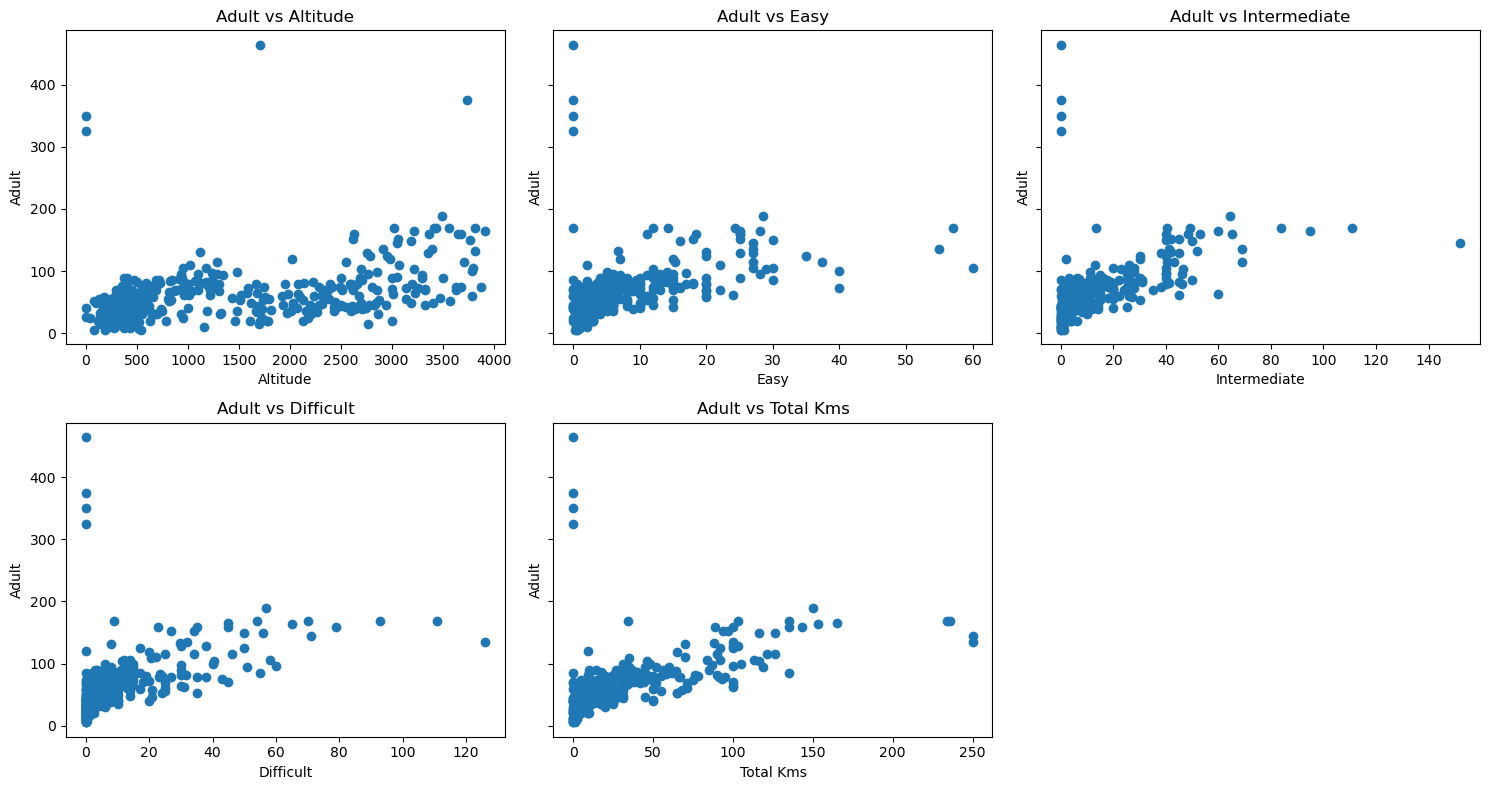

In [6]:
# Create a figure and axis array with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)

# Remove the last (empty) subplot
fig.delaxes(axes[1, 2])

# List of independent variables
independent_vars = ['Altitude', 'Easy', 'Intermediate', 'Difficult', 'Total Kms']

# Loop through the independent variables and create scatterplots
for i, var in enumerate(independent_vars):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(usdols_c[var], usdols_c['Adult'])
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Adult')
    axes[row, col].set_title(f'Adult vs {var}')

# Adjust the layout for better readability
fig.tight_layout()

# Display the scatterplot subplots
plt.show()

The plots above each show four resorts with very high prices, but extremely low values of the independent variable. We can examine these values and determine if they should be dropped: 

In [7]:
# Find the indices of the largest 4 values in the 'Adult' column
largest_adult_indices = usdols_c['Adult'].nlargest(4).index

# Get the rows with the largest 4 values
largest_adult_rows = usdols_c.loc[largest_adult_indices]

# Print the rows with the largest 4 values
print(largest_adult_rows)

                   NameResort    State/Province  Altitude  Easy  Intermediate  \
3624    cascade-powder-guides  Washington State    1705.0   0.0           0.0   
5273  arpa-snowcats-los-andes        Valparaiso    3740.0   0.0           0.0   
3797                mt-bailey            Oregon       0.0   0.0           0.0   
3625  cataldo-peak-adventures             Idaho       0.0   0.0           0.0   

      Difficult  Adult  Total Kms  
3624        0.0  465.0          0  
5273        0.0  375.0          0  
3797        0.0  350.0          0  
3625        0.0  325.0          0  


None of the above resorts appear to have any skiable area in total kms - combining this fact with the information that, pricewise, these data points appear to be clear outliers, we will drop these rows, and examine any other rows that have no skiable area (in Total Kms only): 

In [8]:
# Drop the rows with the largest 4 values in the 'Adult' column
usdols_c_dropped = usdols_c.drop(largest_adult_indices)

# Find the rows with 'Total Kms' equal to 0
rows_with_zero_kms = usdols_c_dropped.loc[usdols_c_dropped['Total Kms'] == 0]

# Print the rows with 'Total Kms' equal to 0
print(rows_with_zero_kms)

                             NameResort  State/Province  Altitude  Easy  \
3557                           beartown        New York     304.0   0.5   
3572                        bittersweet        Michigan     324.0   0.0   
3631                  chester-bowl-park       Minnesota     380.0   0.6   
3638               cloudmont-ski-resort         Alabama     548.0   0.6   
3640                 cockaigne-ski-area        New York     619.0   0.0   
3646                   cottonwood-butte           Idaho    1707.0   0.0   
3668                  eagle-island-park           Idaho     781.0   0.1   
3670                         eagle-rock    Pennsylvania     550.0   0.0   
3683                       four-seasons        New York     185.0   0.4   
3687              gladstone-sports-park        Michigan     220.0   0.4   
3735                keyes-peak-florence       Wisconsin     450.0   0.5   
3750   living-memorial-park-brattleboro         Vermont     189.0   0.5   
3786           mount-pros

Examining this data, we can see 25 rows with 0 kilometers of total skiable area. While this does not make much sense, we can see that many of these resorts do have extremely small values of 'Easy', 'Intermediate', or 'Difficult' (some have 0 for all). 

Visually examining the ticket data, we can see that, for the most part, these resorts seem to have low prices. Since we might expect that resorts with low prices would have smaller sizes, we can visualize some metrics regarding prices of the US data, and then compare the resorts with total area of 0 to determine whether this data should be kept in our model. 

Below, we generate a histogram and boxplot of the US data and print the mean and median: 

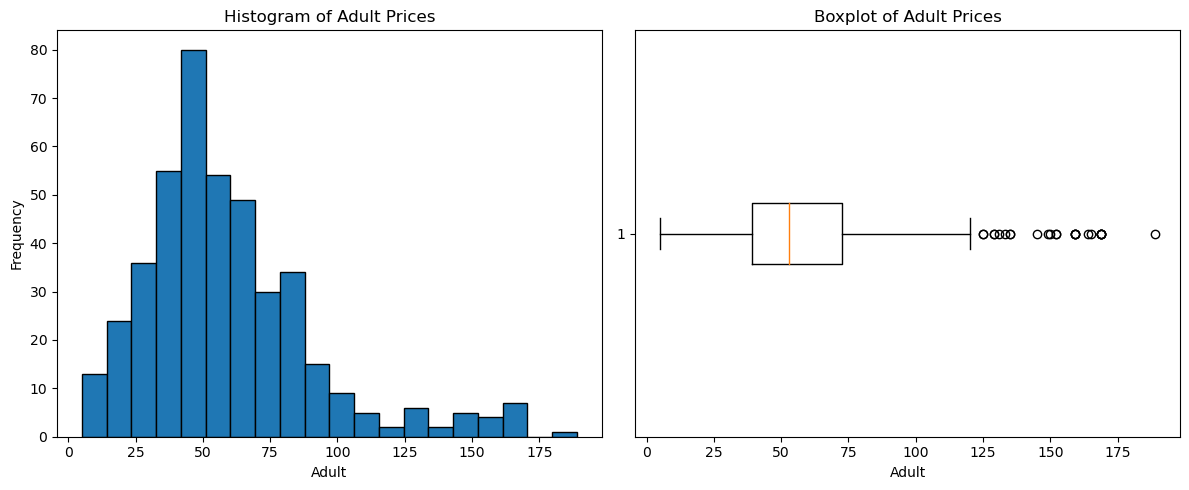

Mean of 'Adult' column: 58.90134570765661
Median of 'Adult' column: 53.0


In [9]:

# Create a figure and axis array with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Create a histogram of the 'Adult' column in the first subplot
axes[0].hist(usdols_c_dropped['Adult'], bins=20, edgecolor='black')
axes[0].set_xlabel('Adult')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Adult Prices')

# Create a boxplot of the 'Adult' column in the second subplot
axes[1].boxplot(usdols_c_dropped['Adult'].dropna(), vert=False)
axes[1].set_xlabel('Adult')
axes[1].set_title('Boxplot of Adult Prices')

# Adjust the layout for better readability
fig.tight_layout()

# Display the subplots
plt.show()

# Calculate the mean and median of the 'Adult' column
mean_adult = usdols_c_dropped['Adult'].mean()
median_adult = usdols_c_dropped['Adult'].median()

# Print the mean and median
print(f"Mean of 'Adult' column: {mean_adult}")
print(f"Median of 'Adult' column: {median_adult}")

Visually examining these plots and looking at the mean and median values tells us that a large amount of data for adult ticket prices are centered around these two estimations of the average. The histogram of prices almost appears normally distributed, except for the long right tail - the boxplot corroborates a large skew to the right with lots of data above the $\text{Q3 + 1.5*IQR}$ range. 

When we visually examine the scatterplots created above, we can see a somewhat positive correlation between every predictor and Adult ticket prices (this will become more apparent visually when we re-plot the data below with the obvious outliers removed). Because of these positive correlations, we should expect that resorts with higher ticket prices will tend to have larger size in total skiable kilometers. Since this is what we expect to be the case, we can decide that any resort that has an adult ticket price above the median of approximately $53 (the median is a more robust measurement of the average, especially considering the right-skew of the data), but also shows 0 kilometers of total skiable area, is likely an error in measurement, while anything below is more realistic, and could be of a very small size anyway, so having the total size as a zero should not significantly alter our model. However, it makes little sense that a resort more expensive than the average would be small, so we will remove these values: 

In [10]:
# Filter the rows based on the specified conditions
filtered_usdols = usdols_c_dropped.loc[~((usdols_c_dropped['Adult'] > median_adult) & (usdols_c_dropped['Total Kms'] == 0))]

There appears to have been one row from "usdols_c_dropped"  that shows a resort with an altitude of zero. Let us examine any rows with no altitude: 

In [11]:
rows_with_zero_alt = filtered_usdols.loc[filtered_usdols['Altitude'] == 0]
print(rows_with_zero_alt)

          NameResort State/Province  Altitude  Easy  Intermediate  Difficult  \
3838  oglebay-resort  West Virginia       0.0   1.0           0.0        0.0   
3895     sawkill-ski       New York       0.0   0.0           0.0        0.0   

      Adult  Total Kms  
3838   26.0          1  
3895   40.0          0  


Only two resorts have no altitude - these were likely errors in measurement, and we will remove these rows: 

In [12]:
# Drop the rows with an altitude of 0
usdols_c_no_zero_altitude = filtered_usdols.loc[filtered_usdols['Altitude'] != 0]

# Rename the DataFrame for clarity
cleaned_usdols = usdols_c_no_zero_altitude

cleaned_usdols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 3517 to 4036
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NameResort      425 non-null    object 
 1   State/Province  425 non-null    object 
 2   Altitude        425 non-null    float64
 3   Easy            425 non-null    float64
 4   Intermediate    425 non-null    float64
 5   Difficult       425 non-null    float64
 6   Adult           425 non-null    float64
 7   Total Kms       425 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 29.9+ KB


#### Cleaned Data Visualization and Analysis - US 

Now let us visualize and analyze the cleaned US data: 

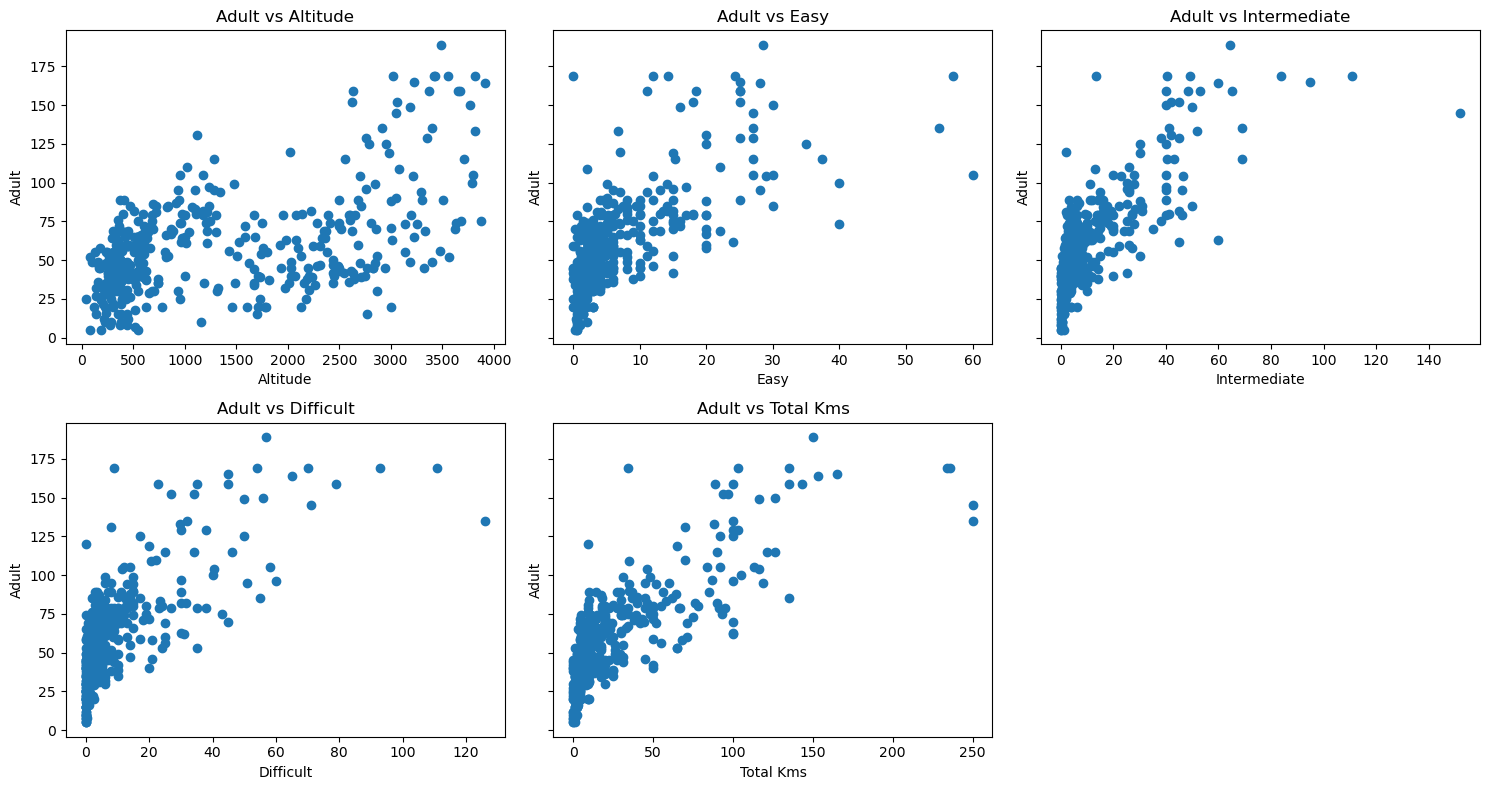

In [13]:
# Create a figure and axis array with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)

# Remove the last (empty) subplot
fig.delaxes(axes[1, 2])

# List of independent variables
independent_vars = ['Altitude', 'Easy', 'Intermediate', 'Difficult', 'Total Kms']

# Loop through the independent variables and create scatterplots
for i, var in enumerate(independent_vars):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(cleaned_usdols[var], cleaned_usdols['Adult'])
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Adult')
    axes[row, col].set_title(f'Adult vs {var}')

# Adjust the layout for better readability
fig.tight_layout()

# Display the scatterplot subplots
plt.show()

We can see that there appears to be a positive correlation for each predictor with Adult lift ticket prices.It is difficult to determine visually which correlation will be the strongest. To a large extent, the scatterplot of each independent variable shows a large clustering of values low in both the value of the independent variable, and in ticket price, with not much variation until both prices and the values of the independent variable get much higher, at which point there is much more variability, especially in all plots where the independent variable is measured in kilometers (every plot except the altitude plot). 

Let us formalize and visualize these correlations by calculating their coefficients and displaying them below in a matrix: 

/tmp/ipykernel_641/1541243854.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))


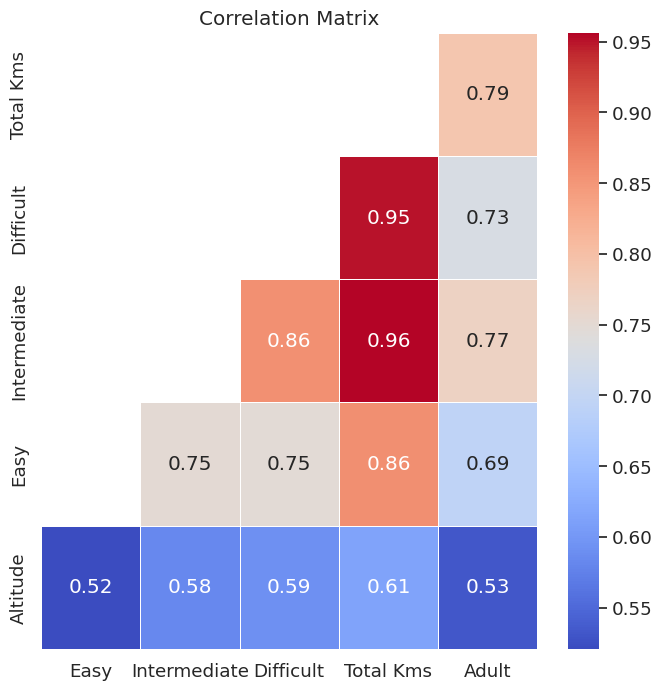

In [14]:
cols = ["Altitude", "Easy", "Intermediate", "Difficult", "Total Kms", "Adult"]
cleaned_usdols_subset = cleaned_usdols[cols]
correlations = cleaned_usdols_subset.corr()
correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))
correlations = correlations.drop(["Adult"], axis=0)
correlations = correlations.drop(["Altitude"], axis=1)

sns.set(font_scale=1.2)
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5, ax=ax)
ax.set_title("Correlation Matrix")
ax.invert_yaxis()
plt.show()

From all the generated visualizations, the most important for a multi-linear regression is undoubtedly the correlation matrix above. Based on this correlation matrix, we can analyze the relationships between these variables and consider potential difficulties in generating a multi-linear regression model to predict the 'Adult' variable.

1. Multicollinearity: There are high correlations between several pairs of independent variables, such as Easy-Intermediate (0.748984), Easy-Difficult (0.748720), Intermediate-Difficult (0.856371), Easy-Total Kms (0.858072), Intermediate-Total Kms (0.956317), and Difficult-Total Kms (0.951210). This multicollinearity might lead to unstable estimates of the regression coefficients and make it difficult to interpret the individual effects of these independent variables on the 'Adult' variable.

2. Moderate correlations with the dependent variable: The independent variables have moderate to strong correlations with the 'Adult' variable, with the highest correlation being 0.790363 for Total Kms. This suggests that these independent variables might be useful in predicting the 'Adult' variable, but there could still be room for improvement in the model's performance.

I can use some of the following methods in my analysis strategy going forward: 

1. Address multicollinearity: To deal with multicollinearity, I can apply one of the following techniques:
- a. Remove one or more of the highly correlated independent variables.
- b. Combine highly correlated independent variables into a single variable, such as creating an average or ratio of related variables.

2. Feature selection: I can apply feature selection techniques, such as stepwise regression, to find the most important independent variables for predicting the 'Adult' variable.

3. Assess model performance: To evaluate the performance of my multi-linear regression model, I can use metrics such as R-squared or Mean Squared Error (MSE). 

4. Consider alternative models: If the multi-linear regression model doesn't perform well, I might consider exploring other predictive models, such as decision trees, support vector machines, or neural networks, to improve prediction accuracy. However, since these models are outside the scope of this class, I may simply have to use one, or a series of, simplistic linear regressions that only predict Adult ticket prices based on a single independent variable at a time. 

By following these strategies, I should be able to create a more robust and accurate multi-linear regression model to predict the 'Adult' variable.

### Cleaning and EDA - European Data

Below, we create a new dataframe and visualize the data information for resorts that charge ticket prices in European Euros: 

In [15]:
eus = skidata.loc[skidata['Currency'] == "European Euro"]

eus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 0 to 5477
Data columns (total 33 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   URL                                                         1473 non-null   object 
 1   Rate                                                        1316 non-null   float64
 2   NameResort                                                  1473 non-null   object 
 3   Stars                                                       299 non-null    float64
 4   Km Freeride                                                 311 non-null    float64
 5   Continent                                                   1473 non-null   object 
 6   Country                                                     1473 non-null   object 
 7   State/Province                                              1473 non-null   object 
 8 

Similar to the US data, we can incorporate Altitude, Easy, Intermediate, Difficult, and Total Kms into our analysis (and we will likely be able to come to more robust conclusions from these measurements, since we have more data here than in the US analysis). The difference between the number of predictor entries and response variable entries for the US data was more stark for any other variables to be included in the US data; however, there is much less of a proportional difference for the following variables: 

- Rate (the overall rating of a resort, out of 5)
- Slope offering, variety of runs (rating out of 5)
- Lifts and cable cars (rating out of 5) 

Firstly, let us visualize the latter two columns named above with histograms to determine what data imputation techniques would be best to use for these columns: 

/tmp/ipykernel_641/3668630342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eus['Lifts and cable cars'] = pd.to_numeric(eus['Lifts and cable cars'].str.replace(',', '.'), errors = 'coerce')


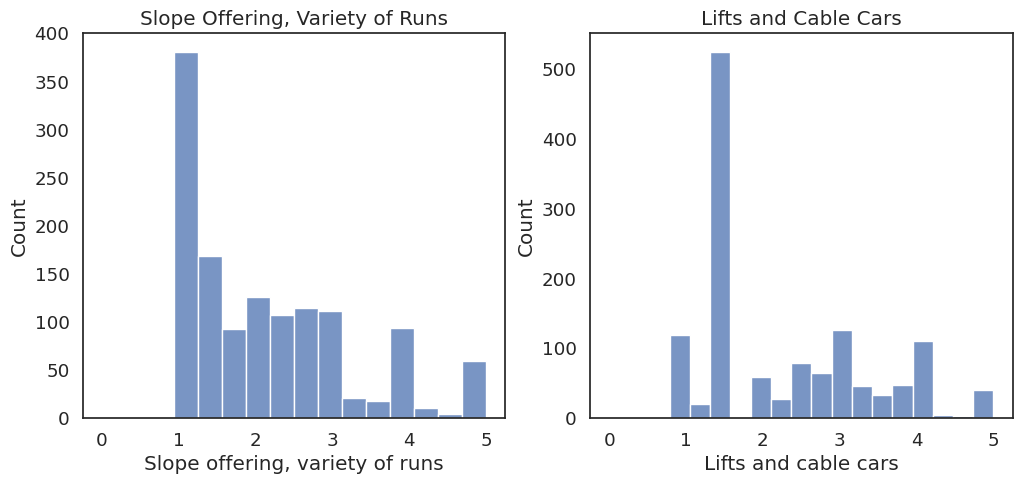

In [16]:
#Change the Lifts and cable cars column to float
eus['Lifts and cable cars'] = pd.to_numeric(eus['Lifts and cable cars'].str.replace(',', '.'), errors = 'coerce')

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot - histogram of 'Slope offering, variety of runs' column
sns.histplot(data=eus, x='Slope offering, variety of runs', ax=axes[0])
axes[0].set_title('Slope Offering, Variety of Runs')

# Second subplot - histogram of 'Lifts and cable cars' column
sns.histplot(data=eus, x='Lifts and cable cars', ax=axes[1])
axes[1].set_title('Lifts and Cable Cars')

# Display the plots
plt.show()

We can see these two histograms are heavily skewed to the right, with both having large peaks at fairly low values. This means using the mean as imputation values is likely not a good choice. Therefore, we will use the median values to impute missing values for these two columns. 

Unlike the two visualized columns above, the 'Rate' column is unique, in that it is likely determined based on other factors of the ski resort, just as we hypothesize that lift ticket prices are. Therefore, we will attempt to fill in missing values of the rate column with a separate multi-linear regression, and use these predicted values to fill in missing values. 

First, let us isolate the data to only factor in the columns that we can safely perform a regression on to predict overall rate: 

In [17]:
# Create a new DataFrame eus_c by dropping the specified columns
columns_to_drop = eus.columns[[0, 3, 4, 5, 13, 14] + list(range(17, 32))]
eus_c = eus.drop(columns_to_drop, axis=1)
eus_c['Adult'] = pd.to_numeric(eus_c['Adult'].str.replace(',', '.'), errors='coerce') 

# Create a boolean mask to filter the rows with null entries
mask = eus_c.isnull().any(axis=1)

# Drop the rows with null entries
eus_c = eus_c.dropna()

eus_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1310 entries, 0 to 5477
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Rate                             1310 non-null   float64
 1   NameResort                       1310 non-null   object 
 2   Country                          1310 non-null   object 
 3   State/Province                   1310 non-null   object 
 4   Altitude                         1310 non-null   float64
 5   Easy                             1310 non-null   float64
 6   Intermediate                     1310 non-null   float64
 7   Difficult                        1310 non-null   float64
 8   Adult                            1310 non-null   float64
 9   Slope offering, variety of runs  1310 non-null   float64
 10  Lifts and cable cars             1310 non-null   float64
 11  Total Kms                        1310 non-null   int64  
dtypes: float64(8), int64

/tmp/ipykernel_641/3633050189.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = eus_c.corr()
/tmp/ipykernel_641/3633050189.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))


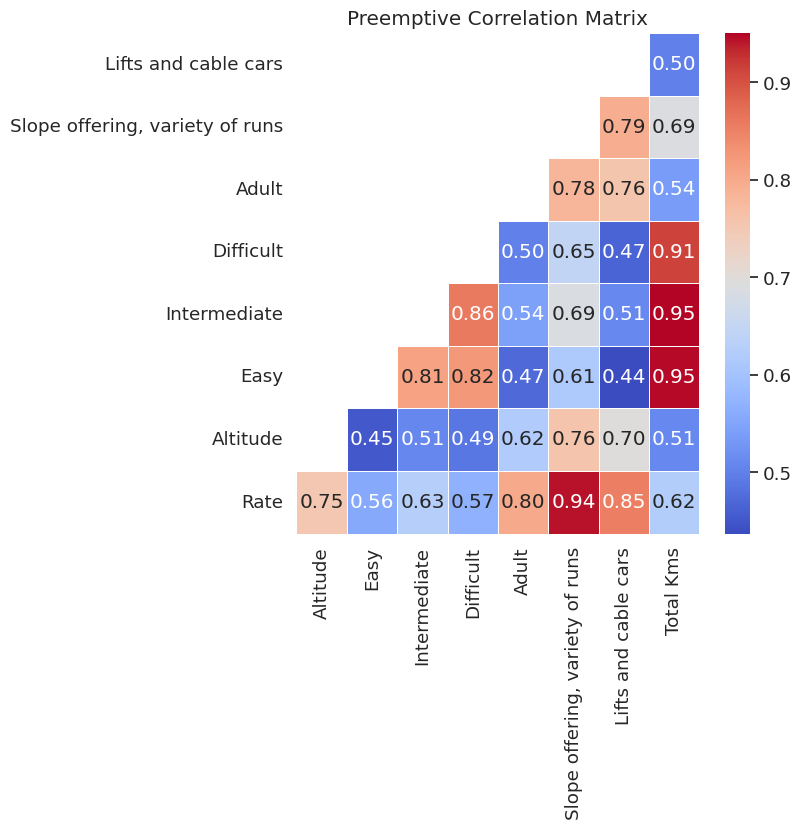

In [18]:
# Calculate the correlation matrix
correlations = eus_c.corr()

# Remove the lower triangle of the correlation matrix
correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))
correlations = correlations.drop(["Rate"], axis = 1)
correlations = correlations.drop(["Total Kms"], axis = 0)

# Configure seaborn settings
sns.set(font_scale=1.2)
sns.set_style(style='white')

# Create the heatmap
fig, ax = plt.subplots(figsize=(6.5, 6.5))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5, ax=ax)
ax.set_title("Preemptive Correlation Matrix")
ax.invert_yaxis()
plt.show()


We can see warnings for collinearity above. Thought we could perform a lengthy analysis on the multi-linear regression just to predict the "Rate" column, this is not our focus - let us attempt to create a suitable regression which will predict missing values in the "Rate" column so that we may then impute missing data to infer the most critical predictors of price. 

Firstly, we see high correlations with any and all factors relating to total skiable area in kilometers. Let us simply remove the 'Easy', 'Intermediate', and 'Difficult' columns and only use the 'Total Kms' column, since we may assume that, as the size of a resort in total skiable area increases, total types of all three difficulties of slopes will increase as well. Let us also remove the 'Adult' column, since we will be using the 'Rate' column to predict adult ticket prices ultimately, and we shouldn't have circular reasoning in how we predict missing values here. Let us also create one column that is the average of the slope variety rating and lift and cable car rating, since these seem to be highly correlated with each other. 

We do all of this and then re-create a new correlation matrix below: 

/tmp/ipykernel_641/3489228466.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = eus_d.corr()
/tmp/ipykernel_641/3489228466.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))


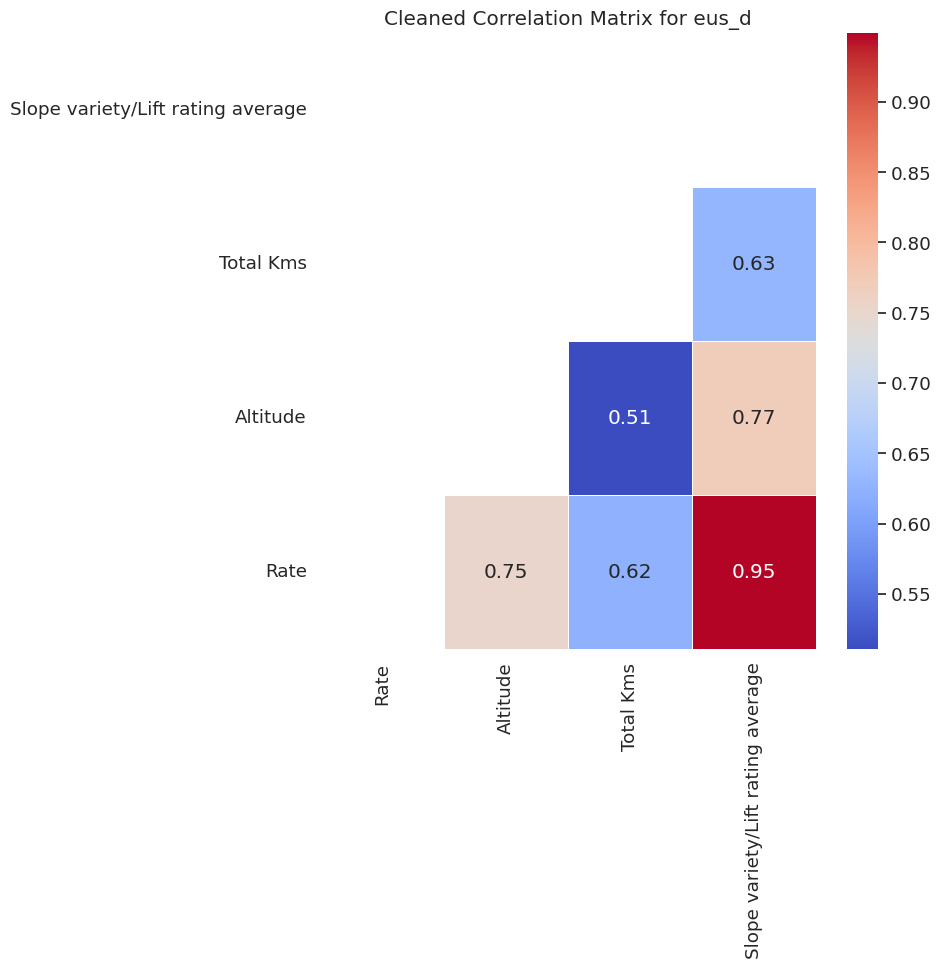

In [19]:
# Create a new DataFrame eus_d by dropping the specified columns
eus_d = eus_c.drop(['Easy', 'Intermediate', 'Difficult', 'Adult'], axis=1)

# Calculate the average of 'Slope offering, variety of runs' and 'Lifts and cable cars' columns
eus_d['Slope variety/Lift rating average'] = (eus_d['Slope offering, variety of runs'] + eus_d['Lifts and cable cars']) / 2

# Drop the original 'Slope offering, variety of runs' and 'Lifts and cable cars' columns
eus_d = eus_d.drop(['Slope offering, variety of runs', 'Lifts and cable cars'], axis=1)

# Calculate the correlation matrix
correlations = eus_d.corr()

# Remove the lower triangle of the correlation matrix
correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))

# Configure seaborn settings
sns.set(font_scale=1.2)
sns.set_style(style='white')

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5, ax=ax)
ax.set_title("Cleaned Correlation Matrix for eus_d")
ax.invert_yaxis()
plt.show()

This correlation matrix still has some cause for concern over collinearity, but much less than the previous matrix. Now we can perform a regression to predict the missing values for the "Rate" column: 

In [20]:
# Drop the 'NameResort', 'Country', and 'State/Province' columns
eus_d = eus_d.drop(['NameResort', 'Country', 'State/Province'], axis=1)

# Create the multi-linear regression model
X = eus_d.drop('Rate', axis=1)
X = sm.add_constant(X)  # Add a constant term to the predictors
y = eus_d['Rate']

model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     4046.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        03:55:19   Log-Likelihood:                -383.59
No. Observations:                1310   AIC:                             775.2
Df Residuals:                    1306   BIC:                             795.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

We can see that this predictive regression for Rate has both favorable qualities and unfavorable. The r-squared value is above 0.9, which means the model is a good fit for the data, and that all p-values are very small, indicating that each independent variable is statistically significant in terms of how much each factors into the calculation of rate. However, there is a large condition number, which is indicative of strong multicollinearity issues. Considering that we attempted to resolve the multicollinearity issue as much as possible, and considering that this is only a predictive model to fill in some missing data, we will use this model to impute values into our original eus dataframe. However, we will keep in mind the limitations of this model as we move forward. 

In [21]:
eus_e = eus.drop(columns_to_drop, axis=1)

# Drop the 'NameResort', 'Country', and 'State/Province' columns
eus_e = eus_e.drop(['NameResort', 'Country', 'State/Province'], axis=1)

# Fill missing values in the 'Slope offering, variety of runs' and 'Lifts and cable cars' columns with their medians
eus_e['Slope offering, variety of runs'] = eus_e['Slope offering, variety of runs'].fillna(eus_e['Slope offering, variety of runs'].median())
eus_e['Lifts and cable cars'] = eus_e['Lifts and cable cars'].fillna(eus_e['Lifts and cable cars'].median())

# Create a new column with the average of the 'Slope offering, variety of runs' and 'Lifts and cable cars' columns
eus_e['Slope variety/Lift rating average'] = (eus_e['Slope offering, variety of runs'] + eus_e['Lifts and cable cars']) / 2

# Use the regression model to predict missing values in the 'Rate' column
missing_rate_rows = eus_e['Rate'].isnull()
X_missing = eus_e.loc[missing_rate_rows, ['Altitude', 'Total Kms', 'Slope variety/Lift rating average']]
# Add a column with the constant coefficient from the model to X_missing
X_missing.insert(0, 'const', 0.0445)
predicted_rates = model.predict(X_missing)

#Replace the missing 'Rate' values with the predicted values
eus_e.loc[missing_rate_rows, 'Rate'] = predicted_rates

eus_imp = eus_e #Re-named for clarity.

eus_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 0 to 5477
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rate                               1473 non-null   float64
 1   Altitude                           1473 non-null   float64
 2   Easy                               1473 non-null   float64
 3   Intermediate                       1473 non-null   float64
 4   Difficult                          1473 non-null   float64
 5   Adult                              1473 non-null   object 
 6   Slope offering, variety of runs    1473 non-null   float64
 7   Lifts and cable cars               1473 non-null   float64
 8   Total Kms                          1473 non-null   int64  
 9   Slope variety/Lift rating average  1473 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 126.6+ KB


Now that we have imputed values for our EU data, let us create scatterplots and visually scan for any outliers, just as we did for the US data: 

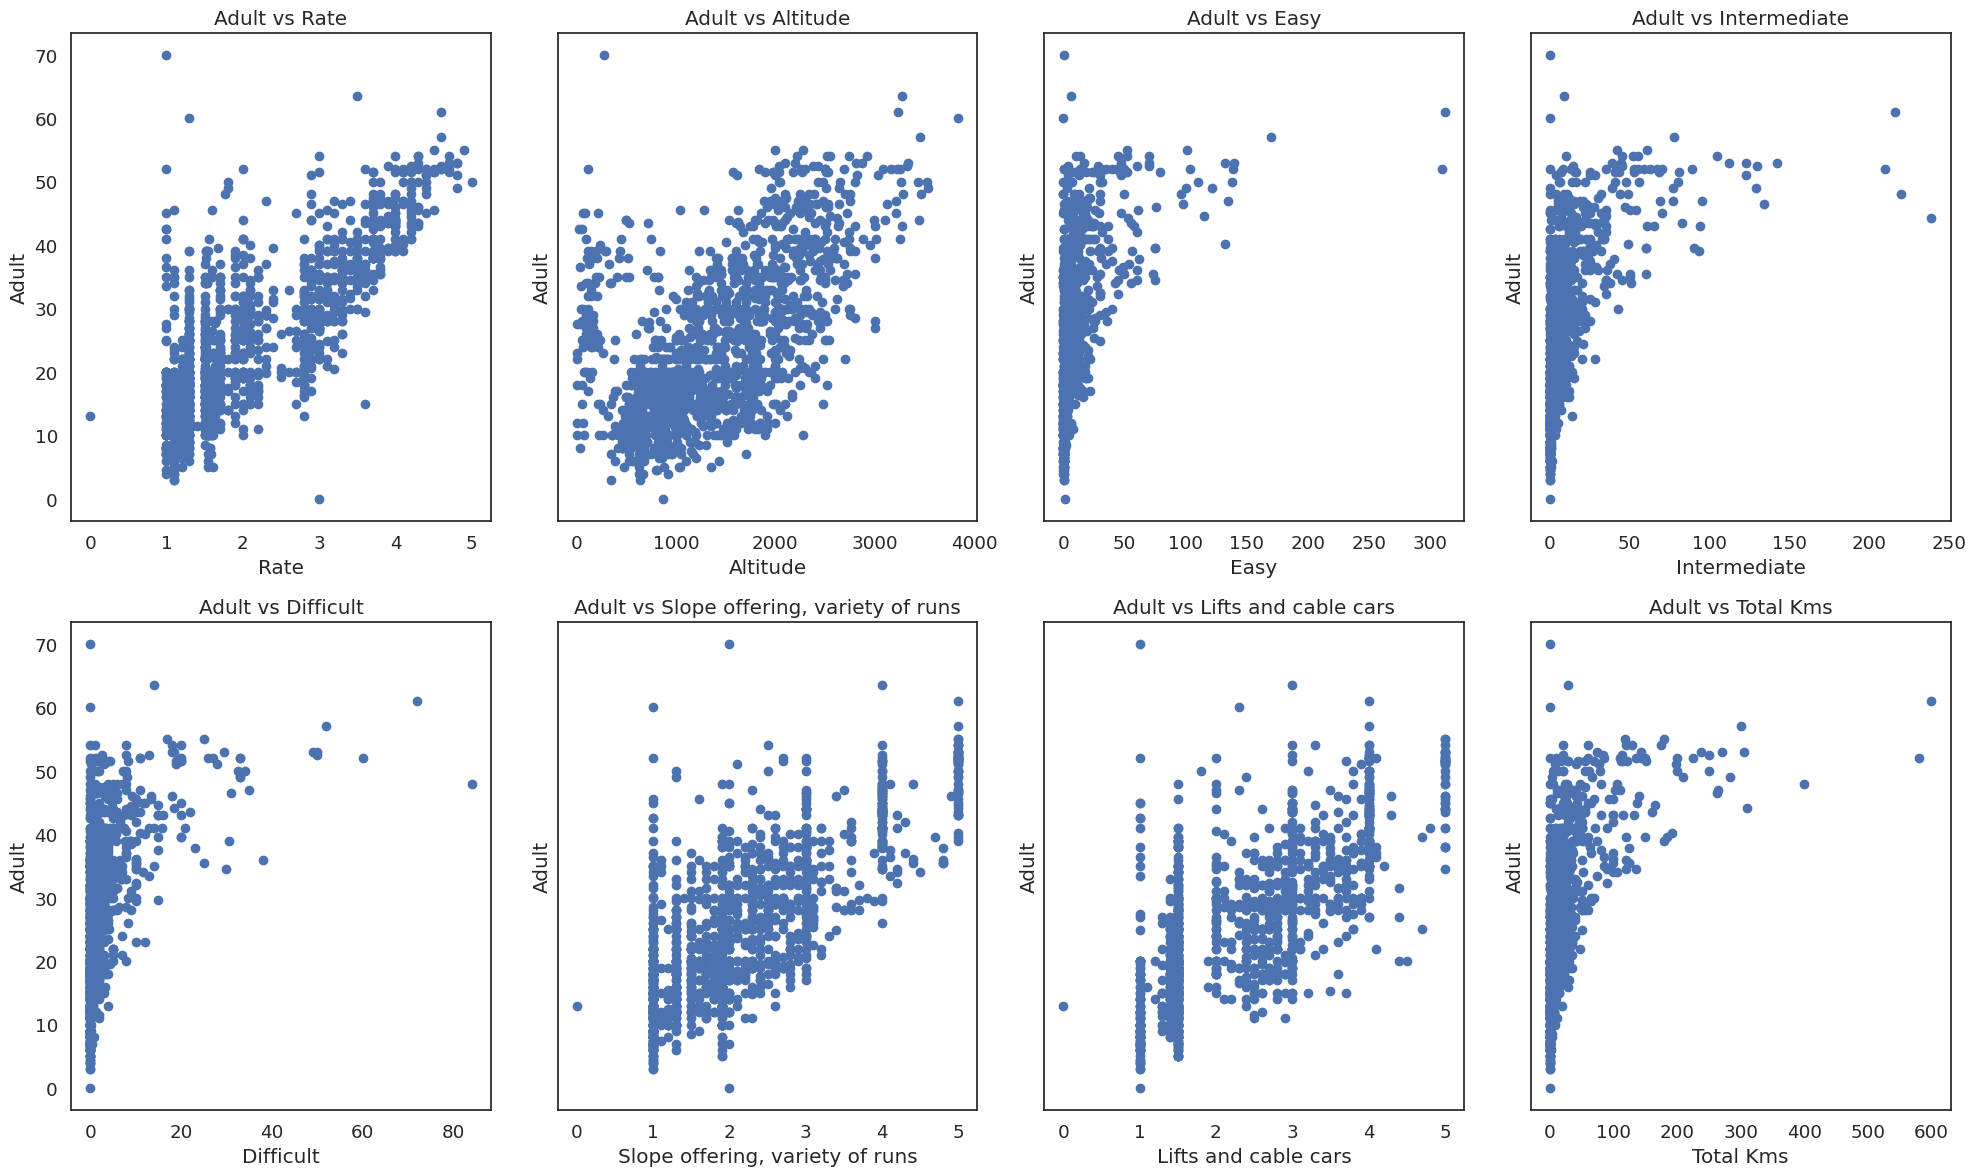

In [22]:
# Change the 'Adult' column from type object to type float
eus_imp['Adult'] = eus_imp['Adult'].apply(lambda x: float(str(x).replace(',', '.')))

#Let us drop the slope variety/lift rating average for now - we may need this column later if the two columns are still highly correlated
eus_imp_wa = eus_imp.drop('Slope variety/Lift rating average', axis = 1) 

# Create a figure and axis array with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(20, 12), sharey=True)

# List of independent variables
independent_vars = eus_imp_wa.drop('Adult', axis=1).columns

# Loop through the independent variables and create scatterplots
for i, var in enumerate(independent_vars):
    row = i // 4
    col = i % 4
    axes[row, col].scatter(eus_imp_wa[var], eus_imp_wa['Adult'])
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Adult')
    axes[row, col].set_title(f'Adult vs {var}')

# Adjust the layout for better readability
fig.tight_layout()

# Display the scatterplot subplots
plt.show()

Inspecting these plots, there appears to be one clear outlier with a '0' rating for a few plots - this is odd, since every other rating is somewhere between 1 and 5. There also appears to be a few points with an Adult price of 0 euros or very close to zero - we will inspect this as well, since this is unusual. As before with the US data, there also appear to be a few data points with very high values of the dependent variable but very low values of the independent variable - these will be inspected as well. It should be noted that there are some noticeable outliers with high values of both the dependent and corresponding independent variable, but these are likely simply very large ski resorts with high ticket prices, which we would expect at least theorhetically - we will keep these outliers in mind but try to incorporate them into our model. 

In [23]:
# Find the index of the minimum value in the 'Rate' column
min_rate_idx = eus_imp_wa['Rate'].idxmin()

# Display the row with the minimum value of the 'Rate' column
minimum_rate_row = eus_imp_wa.loc[min_rate_idx]
print(minimum_rate_row)

Rate                                 0.0
Altitude                           637.0
Easy                                 0.0
Intermediate                         0.4
Difficult                            0.0
Adult                               13.0
Slope offering, variety of runs      0.0
Lifts and cable cars                 0.0
Total Kms                            0.0
Name: 2295, dtype: float64


The above resort has nonsensical values; we will drop it, and then examine the resorts with the five lowest ticket prices: 

In [24]:
# Drop the row with the minimum 'Rate' value
eus_imp_wa = eus_imp_wa.drop(min_rate_idx)

# Display the rows with the 5 lowest values in the 'Adult' column
lowest_adult_rows = eus_imp_wa.nsmallest(5, 'Adult')
print(lowest_adult_rows)

      Rate  Altitude  Easy  Intermediate  Difficult  Adult  \
112    3.0     865.0   1.7           0.1        0.0   0.01   
1975   1.1     640.0   0.3           0.0        0.0   3.00   
2462   1.1     347.0   0.4           0.0        0.0   3.00   
2066   1.1     670.0   0.4           0.0        0.0   4.00   
2146   1.0     625.0   0.2           0.0        0.0   4.00   

      Slope offering, variety of runs  Lifts and cable cars  Total Kms  
112                               2.0                   1.0          1  
1975                              1.0                   1.0          0  
2462                              1.0                   1.0          0  
2066                              1.0                   1.0          0  
2146                              1.0                   1.0          0  


The resort with a lift ticket price of 0.01 euro is absurdly low - we will drop this value, then, as with the US data, display a histogram and a box plot of the Adult ticket prices to determine if any resorts with a 'Total Kms' value of zero should be dropped: 

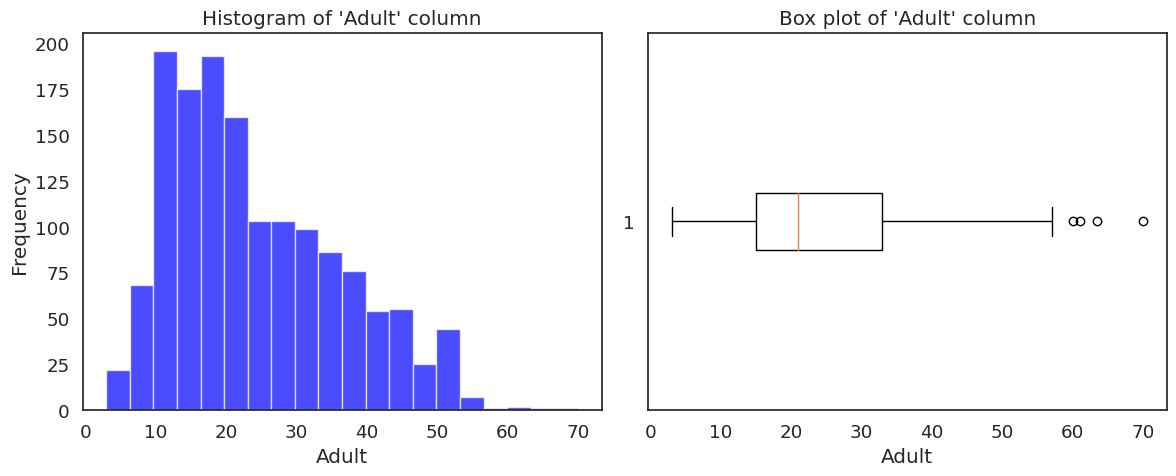

Mean of the 'Adult' column: 24.29483344663494
Median of the 'Adult' column: 21.0


In [25]:
# Find the index of the lowest value in the 'Adult' column
lowest_adult_idx = eus_imp_wa['Adult'].idxmin()

# Drop the row with the lowest value in the 'Adult' column
eus_imp_wa = eus_imp_wa.drop(lowest_adult_idx)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram of the 'Adult' column on the first subplot
axes[0].hist(eus_imp_wa['Adult'], bins=20, color='blue', alpha=0.7)
axes[0].set_title("Histogram of 'Adult' column")
axes[0].set_xlabel("Adult")
axes[0].set_ylabel("Frequency")

# Plot the box plot of the 'Adult' column on the second subplot
axes[1].boxplot(eus_imp_wa['Adult'], vert=False)
axes[1].set_title("Box plot of 'Adult' column")
axes[1].set_xlabel("Adult")

# Adjust the layout for better readability
fig.tight_layout()

# Display the subplots
plt.show()

# Calculate the mean and median of the 'Adult' column
mean_adult = eus_imp_wa['Adult'].mean()
median_adult = eus_imp_wa['Adult'].median()

# Print the mean and median of the 'Adult' column
print("Mean of the 'Adult' column:", mean_adult)
print("Median of the 'Adult' column:", median_adult)

Just as with the US data, we see a clear right skew to the data with some high outliers. We will drop any values with a 'Total Kms' of zero with a ticket price above the median of 21 euros. Then, we will examine the data for any values with an altitude of zero and automatically drop those: 

In [26]:
# Drop rows with 'Adult' values below the median and 'Total Kms' equal to 0
eus_imp_wa = eus_imp_wa.drop(
    eus_imp_wa[(eus_imp_wa['Adult'] > median_adult) & (eus_imp_wa['Total Kms'] == 0)].index
)

# Drop rows with 'Altitude' equal to 0
eus_imp_wa = eus_imp_wa.drop(
    eus_imp_wa[eus_imp_wa['Altitude'] == 0].index
)

eus_cleaned = eus_imp_wa

eus_cleaned.info() #Renamed for clarity

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1415 entries, 0 to 5477
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Rate                             1415 non-null   float64
 1   Altitude                         1415 non-null   float64
 2   Easy                             1415 non-null   float64
 3   Intermediate                     1415 non-null   float64
 4   Difficult                        1415 non-null   float64
 5   Adult                            1415 non-null   float64
 6   Slope offering, variety of runs  1415 non-null   float64
 7   Lifts and cable cars             1415 non-null   float64
 8   Total Kms                        1415 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 110.5 KB


#### Cleaned Data Visualization and Analysis - EU

Below we recreate our scatterplots for the cleaned data: 

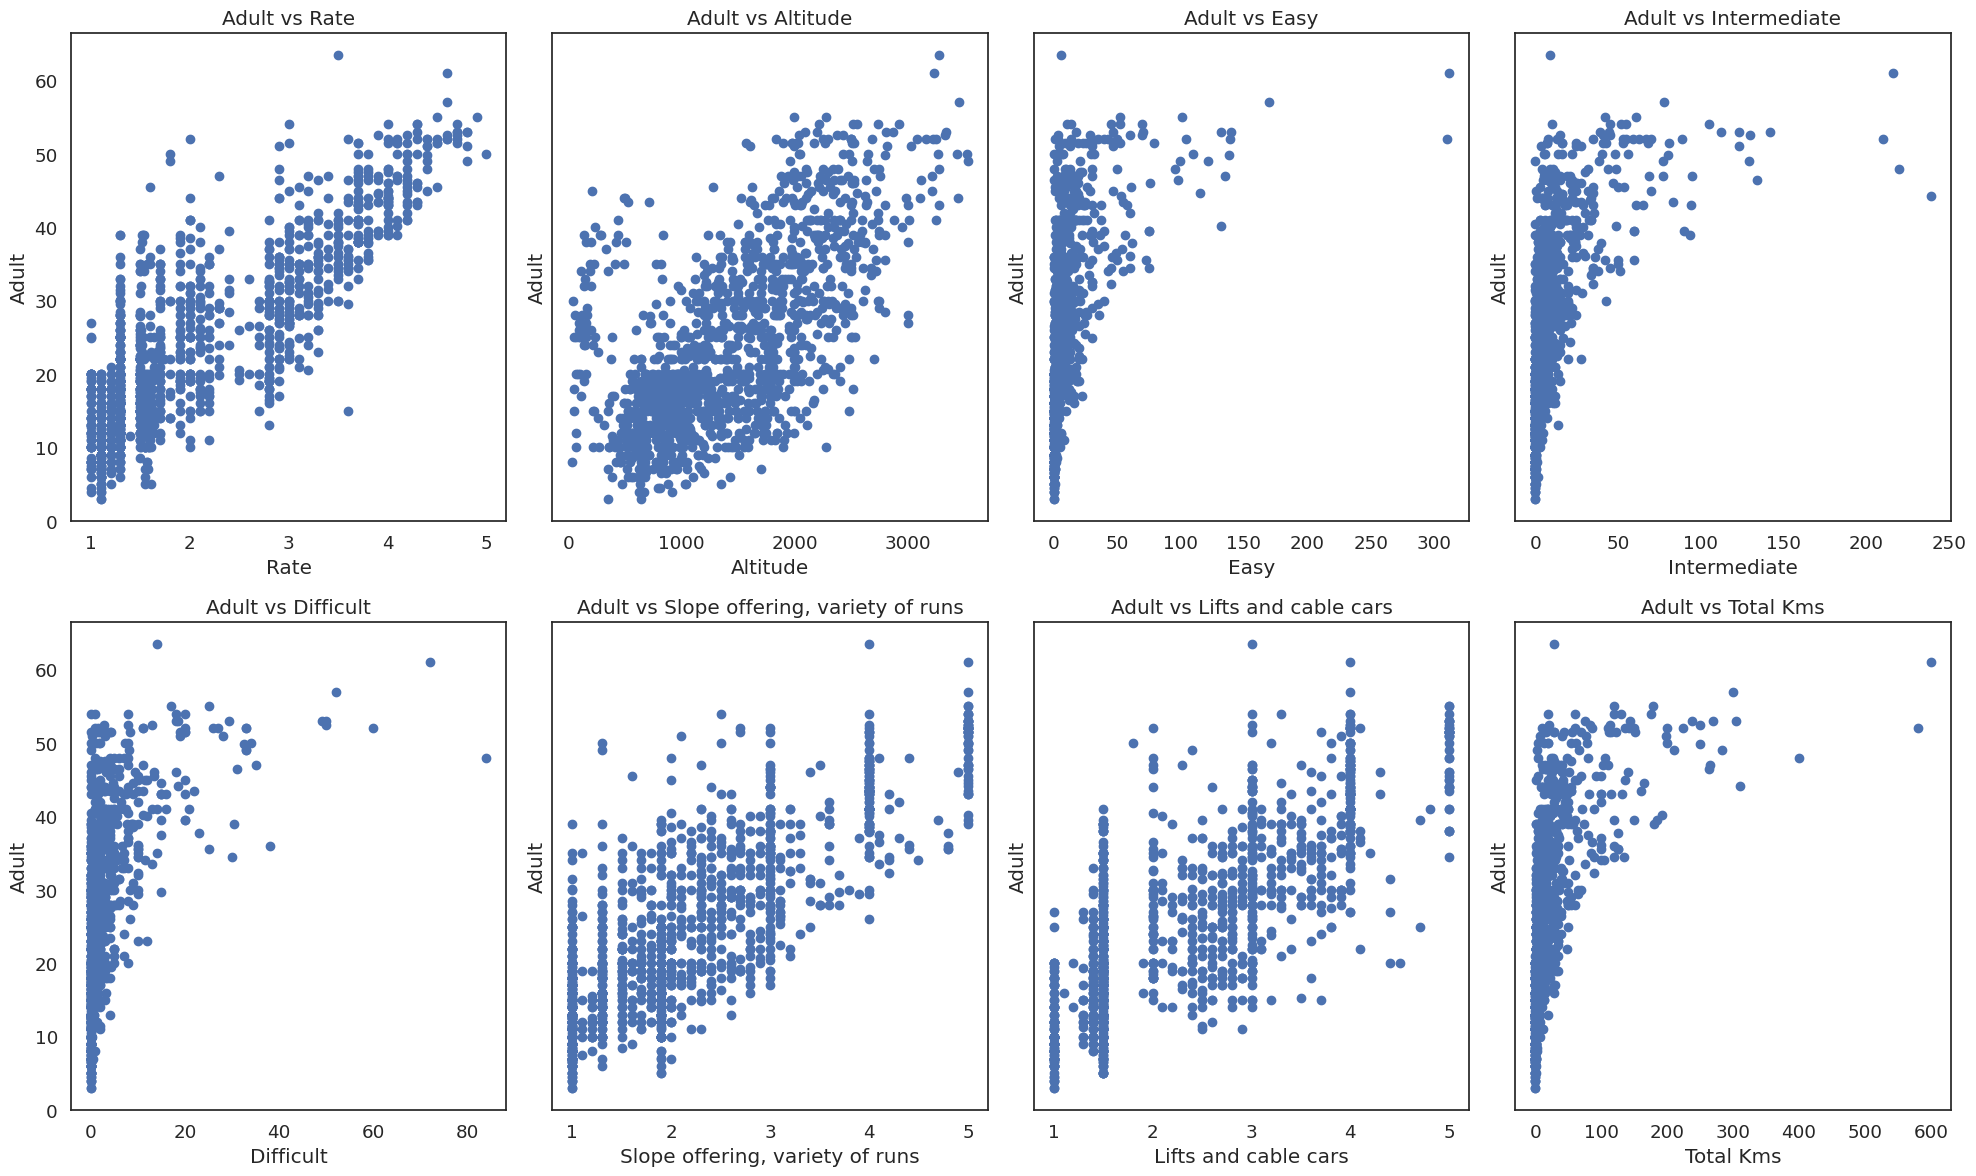

In [27]:
# Create a figure and axis array with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(20, 12), sharey=True)

# List of independent variables
independent_vars = eus_cleaned.drop('Adult', axis=1).columns

# Loop through the independent variables and create scatterplots
for i, var in enumerate(independent_vars):
    row = i // 4
    col = i % 4
    axes[row, col].scatter(eus_cleaned[var], eus_cleaned['Adult'])
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Adult')
    axes[row, col].set_title(f'Adult vs {var}')

# Adjust the layout for better readability
fig.tight_layout()

# Display the scatterplot subplots
plt.show()

Again, we see positive correlations with every predictor, with large clustering of data at low values and much more variability as we increase values in both the x and y-axes. 

Below, we calculate a correlation matrix: 

/tmp/ipykernel_641/770907299.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))


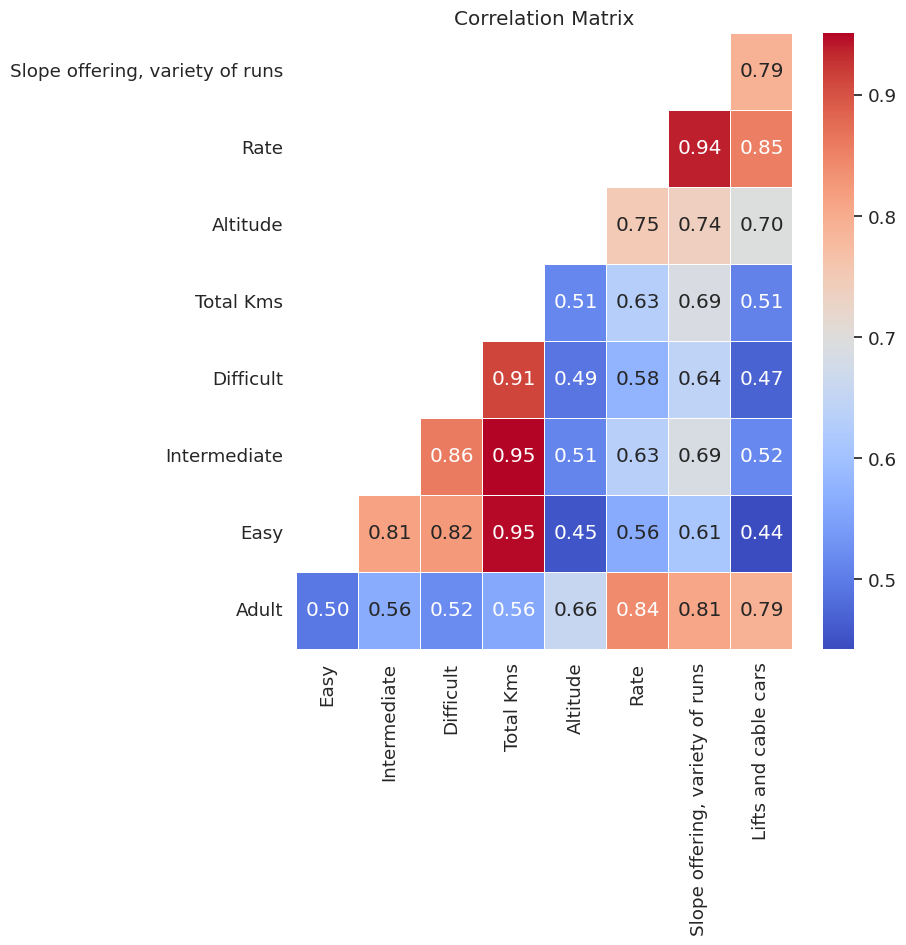

In [28]:
cols = ["Adult", "Easy", "Intermediate", "Difficult", "Total Kms", "Altitude", "Rate", "Slope offering, variety of runs", 
       "Lifts and cable cars"]
cleaned_eus_subset = eus_cleaned[cols]
correlations = cleaned_eus_subset.corr()
correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))
correlations = correlations.drop(["Lifts and cable cars"], axis=0)
correlations = correlations.drop(["Adult"], axis=1)

sns.set(font_scale=1.2)
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5, ax=ax)
ax.set_title("Correlation Matrix")
ax.invert_yaxis()
plt.show()

We see similar data to what we expected from generating the predictive regression for the 'Rate' column - there is extremely strong correlations between all measurements of types of skiable slopes - we will simply drop the three difficulty ratings and only factor in the 'Total Kms' column under the same assumption that, as the total size of a resort increases, so too will every type of difficulty of slope increase. Additionally, we see a strong correlation with 'Rate' and both 'Slope offering, variety of runs' and 'Lifts and cable cars'. This is likely due at least in part to the fact that we used these columns to predict values for the 'Rate' column that were missing. Because of this, we will also drop these two columns and assume that the overall 'Rate' of a resort encapsulates the individual ratings for these two attributes (all of this will be done below in the model section). In the case of the broad EU data, this is probably a more useful analysis than analyzing the relatively niche categorical ratings mentioned above - there simply isn't enough useful data to find whether any niche individual factor influences higher ski prices for all EU resorts. 

However, this is still an interesting question, and it would behoove us to explore it as much as we are able. We can create a separate, small dataframe from the EU data that contains enough data to perform a regression for all variables that were not able to be analyzed for the broad EU data. Though each column will only have 284 entries, and we will likely not be able to generalize anything to a broader scope, it will still provide interesting insights into the most important predictors of lift ticket prices: 

In [29]:
# Create a new DataFrame eus_ratings with specified columns
eus_ratings = eus.iloc[:, [4, 8, 12] + list(range(15, 29)) + [32]]

#NOTE: I did not include the 'Rate' column, because I would like a more specialized model that can incorporate as many
#"niche" rating predictors as possible, instead of the overall rating
#Additionally, I did not include the Easy, Intermediate, or Difficult columns, as previous analysis has shown that 
#these are highly correlated with the Total Kms value

# Drop rows with any null values
eus_ratings = eus_ratings.dropna()

# Identify object type columns
object_columns = eus_ratings.select_dtypes(include='object').columns

# Convert object type columns to float and replace commas with decimals
for col in object_columns:
    eus_ratings[col] = eus_ratings[col].str.replace(',', '.').astype(float)

eus_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 0 to 3498
Data columns (total 18 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Km Freeride                                                 284 non-null    float64
 1   Altitude                                                    284 non-null    float64
 2   Adult                                                       284 non-null    float64
 3   Slope offering, variety of runs                             284 non-null    float64
 4   Lifts and cable cars                                        284 non-null    float64
 5   Snow reliability                                            284 non-null    float64
 6   Access, on-site parking                                     284 non-null    float64
 7   Orientation (trail map, information boards, sign-postings)  284 non-null    float64
 8  

As usual, we create scatterplots for visual indication of correlation. This time, we clean the nonsensical data out first, since we know what we are looking for: 

In [30]:
# Drop the row with the minimum value in the 'Adult' column
min_adult_index = eus_ratings['Adult'].idxmin()
eus_ratings = eus_ratings.drop(min_adult_index)

# Drop rows with the 'Altitude' column equal to 0
eus_ratings = eus_ratings[eus_ratings['Altitude'] != 0]

# Calculate the median of the 'Adult' column
adult_median = eus_ratings['Adult'].median()

# Filter rows where 'Total Kms' is 0 and 'Adult' is greater than the median
filtered_rows = eus_ratings[(eus_ratings['Total Kms'] == 0) & (eus_ratings['Adult'] > adult_median)]

# Drop the filtered_rows from eus_ratings
eus_ratings = eus_ratings.drop(filtered_rows.index)


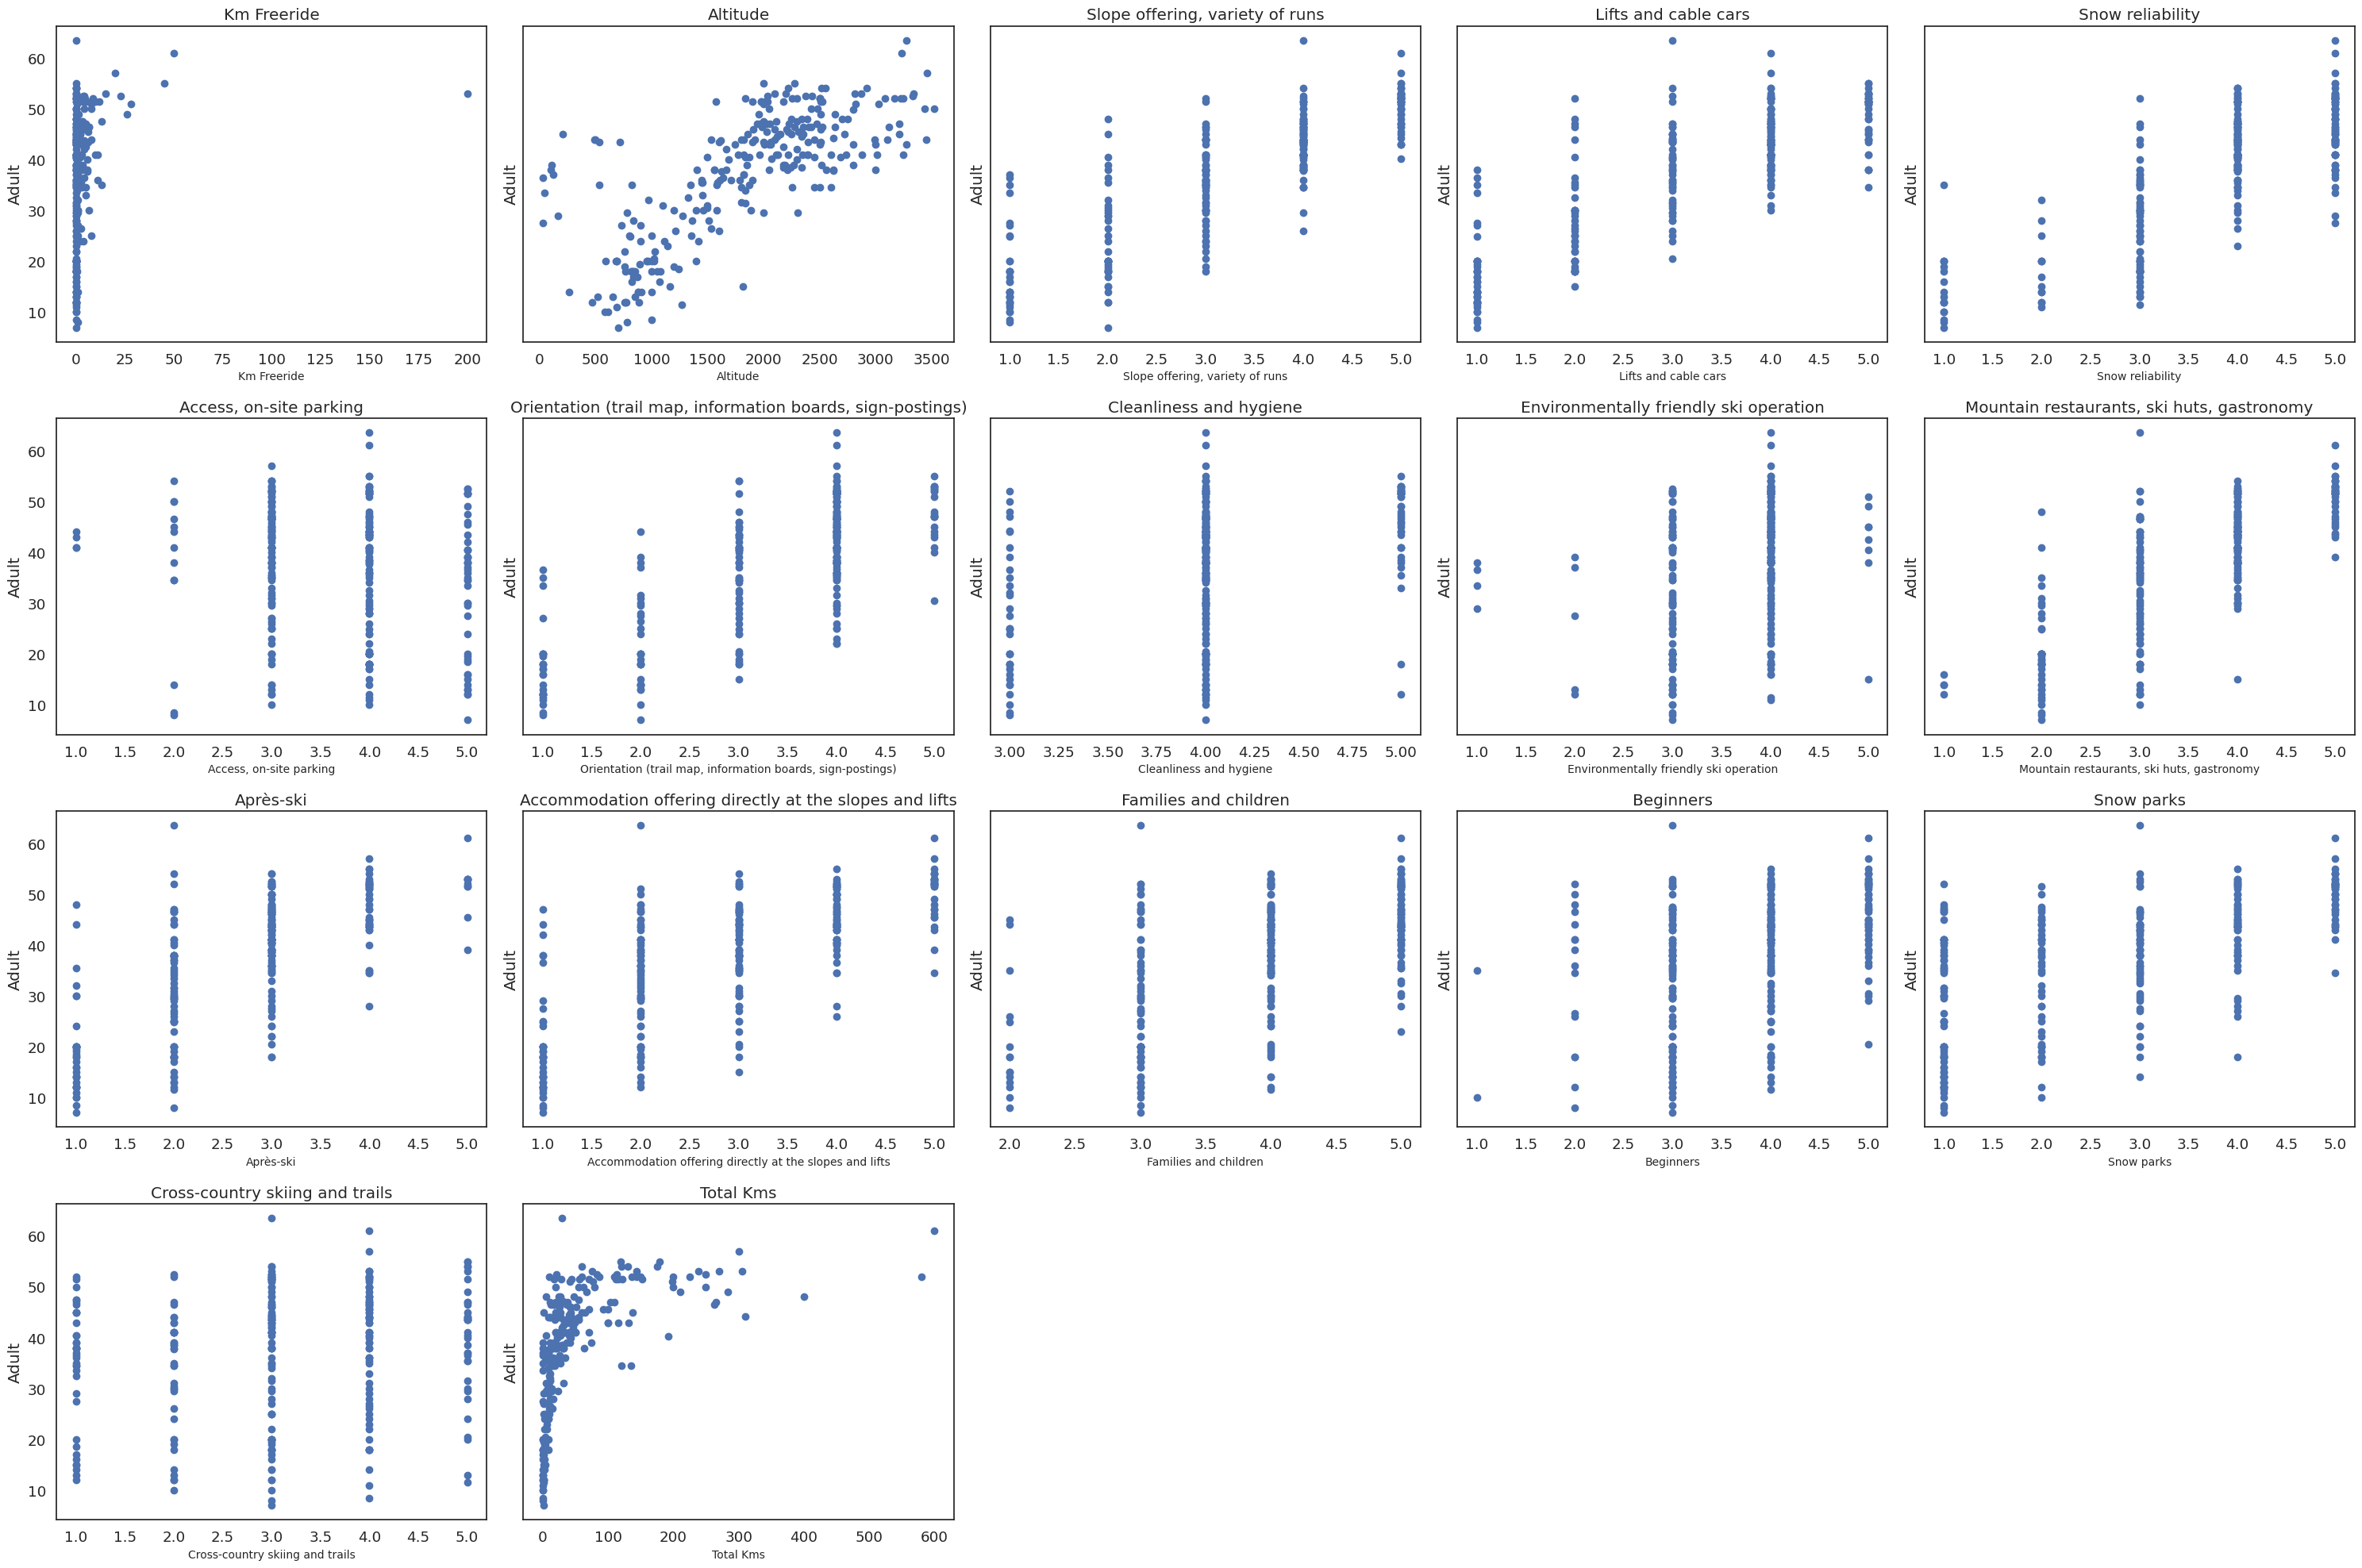

In [31]:
# Create a figure and axis array with 4 rows and 5 columns
fig, axes = plt.subplots(4, 5, figsize=(30, 20), sharey=True)

# Remove the last 3 (empty) subplots
fig.delaxes(axes[3, 2])
fig.delaxes(axes[3, 3])
fig.delaxes(axes[3, 4])

# List of independent variables
independent_vars = eus_ratings.columns.tolist()
independent_vars.remove('Adult')

# Loop through the independent variables and create scatterplots
for i, var in enumerate(independent_vars):
    row = i // 5
    col = i % 5
    axes[row, col].scatter(eus_ratings[var], eus_ratings['Adult'])
    axes[row, col].set_xlabel(var, fontsize=10)
    axes[row, col].set_ylabel('Adult')
    axes[row, col].set_title(var)

# Adjust the layout for better readability
fig.tight_layout()

# Display the scatterplot subplots
plt.show()


While the plots for 'Km Freeride' and 'Total Kms' look familiar, the other plots of ratings look refreshingly different and varied (note that every rating plot are only given integer ratings from 1 - 5). Some plots appear to clearly be correlated with ticket price, while others do not show clear correlations. 

Let us view the correlation matrix: 

/tmp/ipykernel_641/1277326705.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlations_r = correlations_r.mask(np.tril(np.ones(correlations_r.shape)).astype(np.bool))


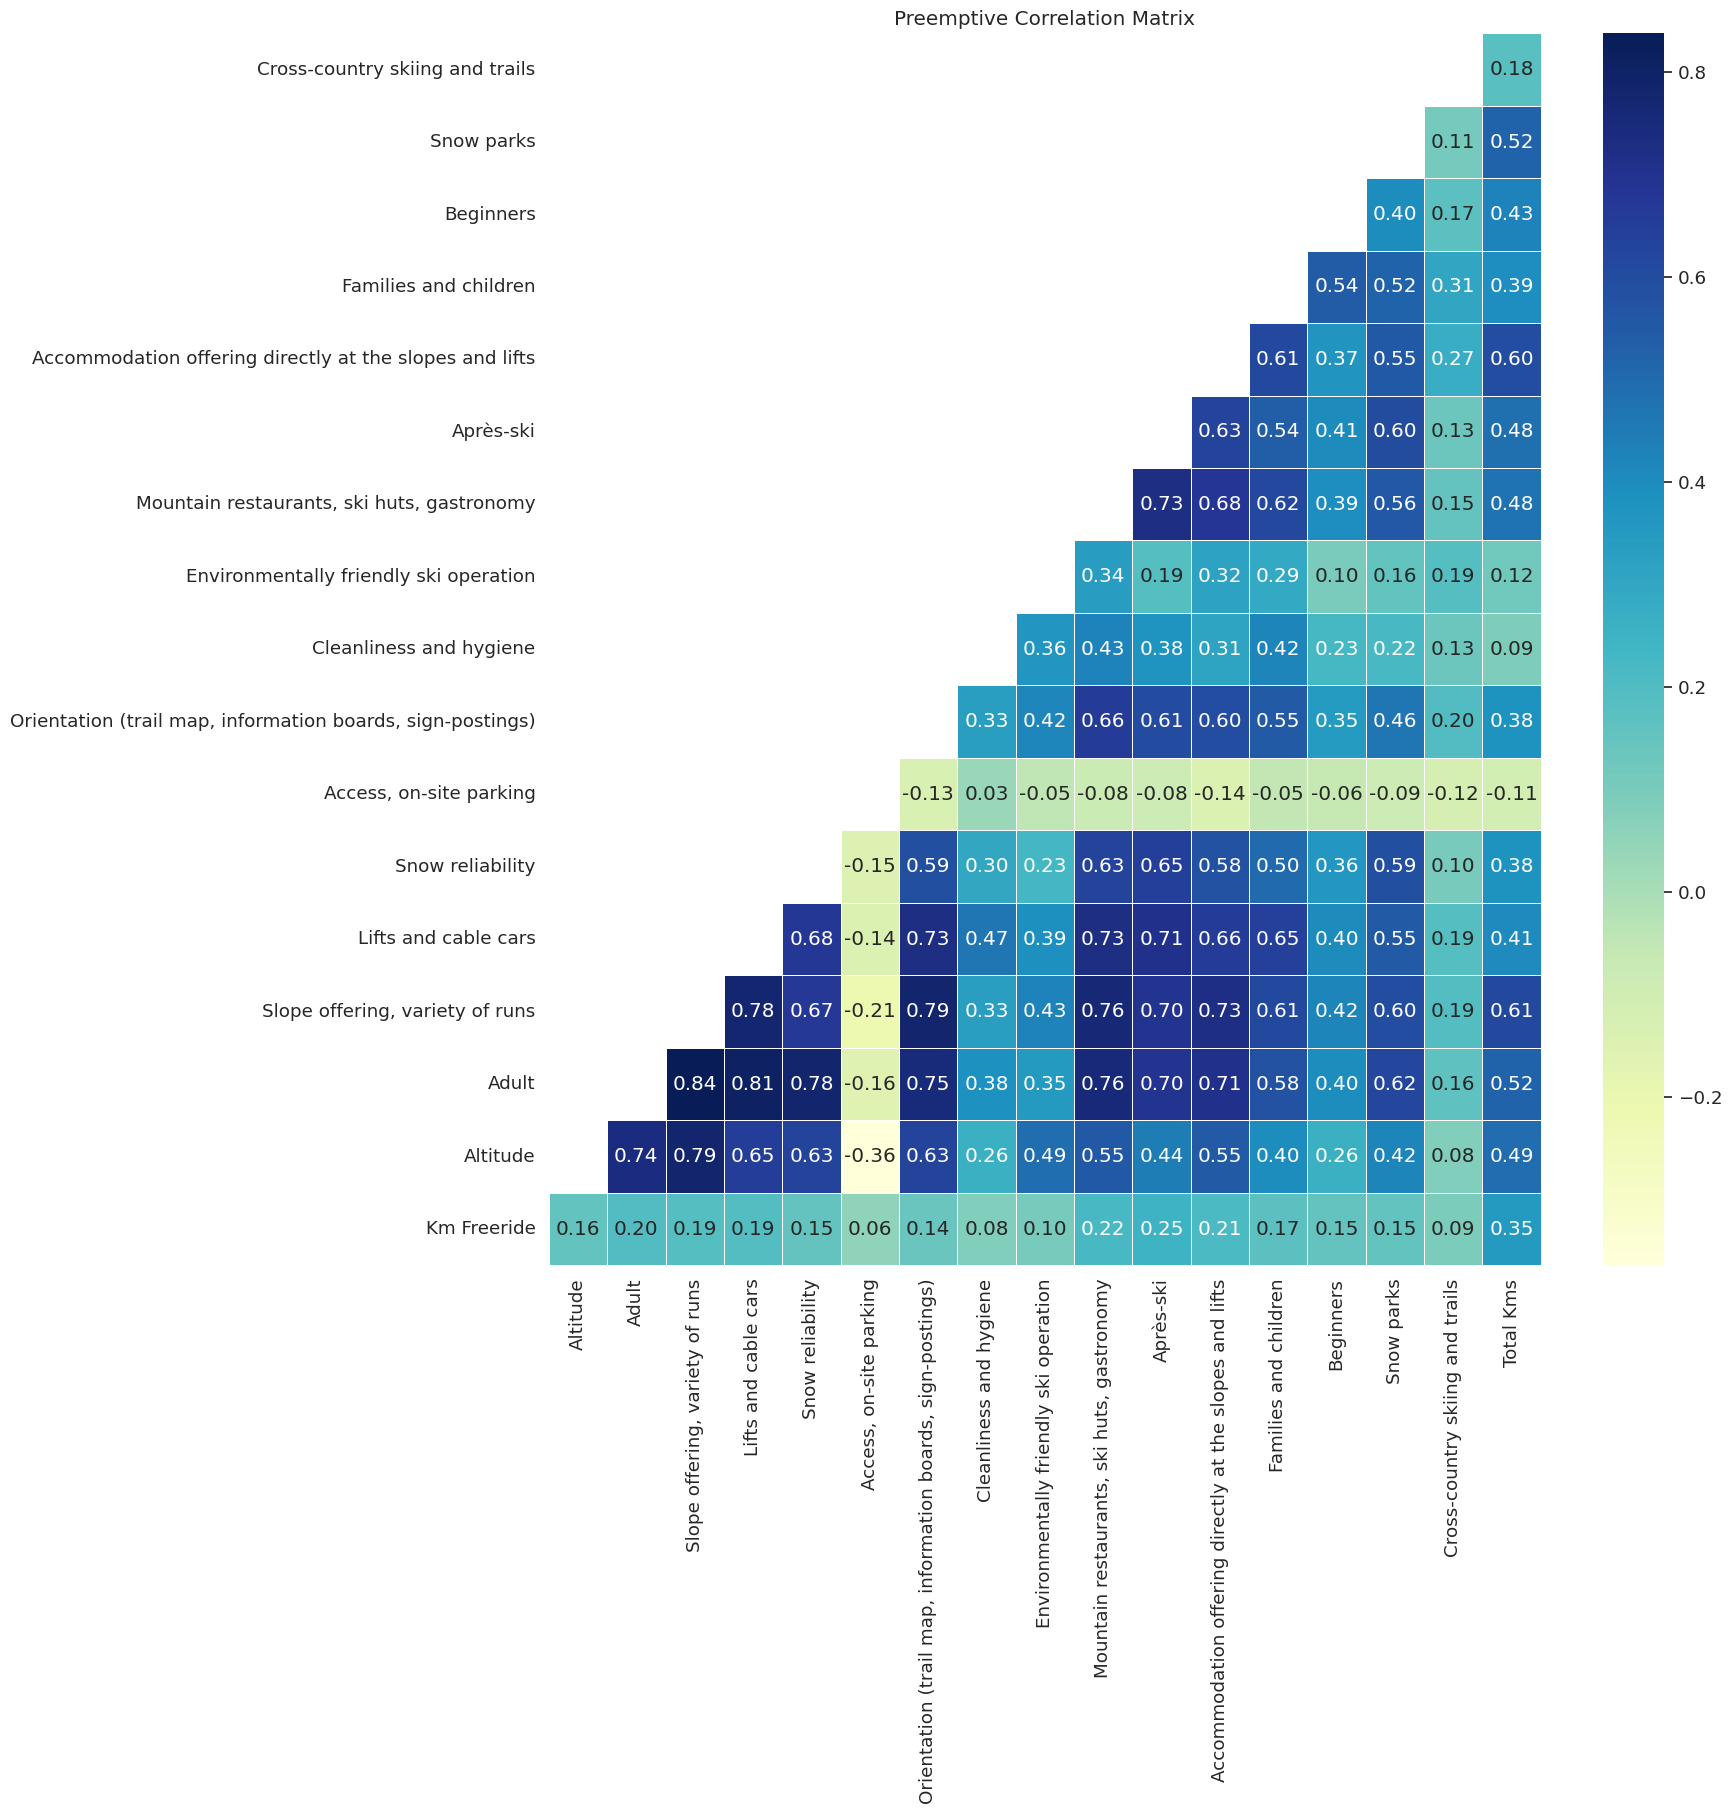

In [32]:
# Calculate the correlation matrix
correlations_r = eus_ratings.corr()

# Remove the lower triangle of the correlation matrix
correlations_r = correlations_r.mask(np.tril(np.ones(correlations_r.shape)).astype(np.bool))
correlations_r = correlations_r.drop(["Km Freeride"], axis = 1)
correlations_r = correlations_r.drop(["Total Kms"], axis = 0)

# Configure seaborn settings
sns.set(font_scale=1.2)
sns.set_style(style='white')

# Create the heatmap
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(correlations_r, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5, ax=ax)
ax.set_title("Preemptive Correlation Matrix")
ax.invert_yaxis()
plt.show()

The correlation matrix above is very interesting, because it appears to show relatively strong correlations (for many variables, but not for all) with the Adult column, but there are also a great many variables that do not show very strong correlations at all with other predictos, meaning that we may be able to generate a fairly robust and reliable model without too many multicollinearity issues. There are still a fair amount of correlations that should be noted as being high (anything above 0.70), but these variables do not appear nearly as overtly correlated as the critical attributes for the broad US and EU data. 

In [33]:
# Find and print pairs of variables with a correlation greater than or equal to 0.7
high_correlations = correlations_r.stack().reset_index()
high_correlations.columns = ['Var1', 'Var2', 'Correlation']
high_correlations = high_correlations[high_correlations['Correlation'] >= 0.7]
# Drop pairs containing 'Adult'
high_correlations = high_correlations[(high_correlations['Var1'] != 'Adult') & (high_correlations['Var2'] != 'Adult')]
print("Pairs of variables with a correlation greater than or equal to 0.7:")
print(high_correlations)

Pairs of variables with a correlation greater than or equal to 0.7:
                                           Var1  \
18                                     Altitude   
48              Slope offering, variety of runs   
51              Slope offering, variety of runs   
54              Slope offering, variety of runs   
56              Slope offering, variety of runs   
64                         Lifts and cable cars   
67                         Lifts and cable cars   
68                         Lifts and cable cars   
125  Mountain restaurants, ski huts, gastronomy   

                                                  Var2  Correlation  
18                     Slope offering, variety of runs     0.785547  
48                                Lifts and cable cars     0.781761  
51   Orientation (trail map, information boards, si...     0.785073  
54          Mountain restaurants, ski huts, gastronomy     0.759769  
56   Accommodation offering directly at the slopes ...     0.725051  
6

## Models

### US Data Models

#### Multi-linear regression

Let us first make some adjustments to the correlation matrix for the cleaned US data, so we can try to minimize multicollinearity issues: 

/tmp/ipykernel_641/3754690416.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))


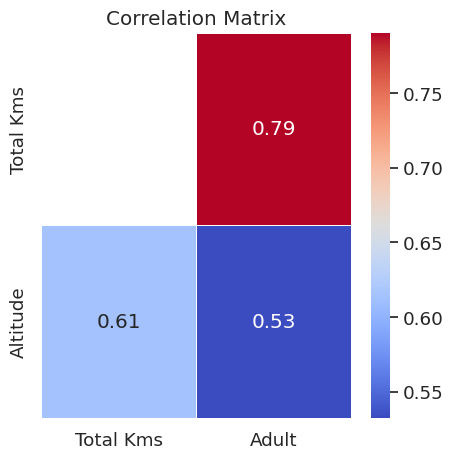

In [34]:
cols = ["Altitude", "Total Kms", "Adult"]
cleaned_usdols_subset = cleaned_usdols[cols]
correlations = cleaned_usdols_subset.corr()
correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))
correlations = correlations.drop(["Adult"], axis=0)
correlations = correlations.drop(["Altitude"], axis=1)

sns.set(font_scale=1.2)
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5, ax=ax)
ax.set_title("Correlation Matrix")
ax.invert_yaxis()
plt.show()

The 'Easy', 'Intermediate', and 'Difficult' columns were all removed due to their strong correlations with each other and with the 'Total Kms' variable. We can see a correlation of medium strength between the two independent variables (Altitude and Total Kms), but it is low enough as to be acceptable for a multi-linear regression: 

In [35]:
# Perform the multi-linear regression
model1 = smf.ols(formula='Adult ~ Altitude + Q("Total Kms")', data=cleaned_usdols_subset).fit()

# Print the regression summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Adult   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     356.6
Date:                Mon, 08 May 2023   Prob (F-statistic):           2.10e-91
Time:                        03:55:28   Log-Likelihood:                -1871.0
No. Observations:                 425   AIC:                             3748.
Df Residuals:                     422   BIC:                             3760.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         39.7411      1.501     26.

Even after dropping some troublesome columns, we are still left with strong multicollinearity issues, and the r-squared value 0f 0.628 indicates that this model only accounts for about 62% of the variability in the data, and could certaintly be improved. 

We can plot the leverage vs the square of the residuals and try to identify some troublesome datapoints to drop: 

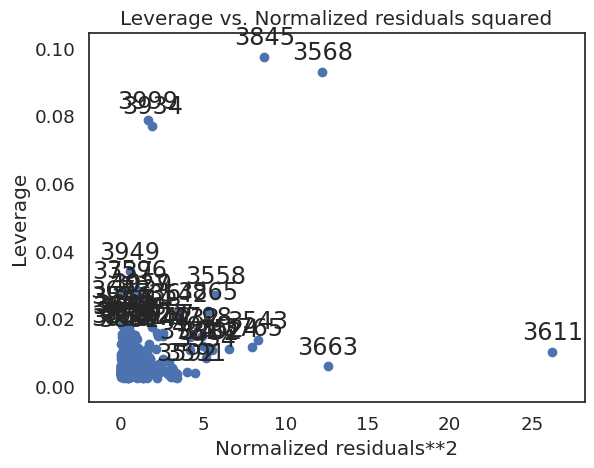

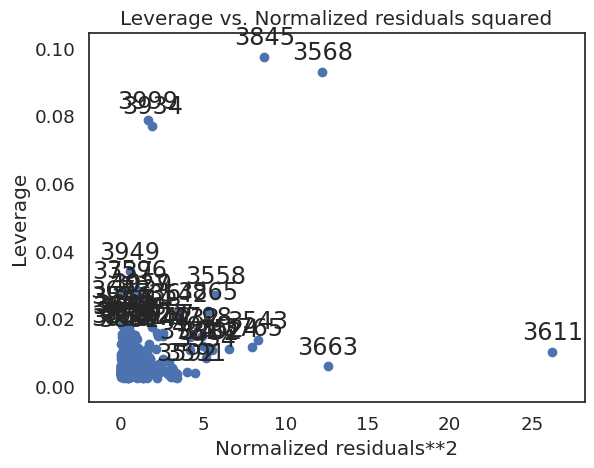

In [39]:
sm.graphics.plot_leverage_resid2(model1, alpha = 0.05)

We see some data points with troublesome leverage vs squared residual values. Let us drop these points and see if our model can be improved: 

In [40]:
# Identify the row numbers of the data points with high leverage and/or high residual squared
influence = model1.get_influence()
leverage = influence.hat_matrix_diag
residuals_squared = influence.resid_studentized_external ** 2

# Define a threshold for high leverage and/or high residual squared
leverage_threshold = 3 * (model.df_model + 1) / model1.nobs
residuals_squared_threshold = np.percentile(residuals_squared, 95)

high_leverage_resid_rows = np.where((leverage > leverage_threshold) | (residuals_squared > residuals_squared_threshold))[0]

# Get the corresponding indices in the DataFrame
high_leverage_resid_indices = cleaned_usdols_subset.iloc[high_leverage_resid_rows].index

# Remove the identified data points from the data
cleaned_usdols_subset_reduced = cleaned_usdols_subset.drop(high_leverage_resid_indices)

# Re-run the multi-linear regression
model_reduced = smf.ols(formula='Adult ~ Altitude + Q("Total Kms")', data=cleaned_usdols_subset_reduced).fit()

# Print the new regression summary
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:                  Adult   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     321.1
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.56e-83
Time:                        03:57:20   Log-Likelihood:                -1667.0
No. Observations:                 398   AIC:                             3340.
Df Residuals:                     395   BIC:                             3352.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         39.8369      1.237     32.

Dropping these data points only results in decreasing our model performance and does not resolve multicollinearity issues. Unfortunately, it appears that Altitude and the total skiable area in kilometers are too related to generate a good multi-linear regression model. Since we only have two predictors, we can also generate two simple linear regressions for each and compare their performance with the multi-linear model.

#### Simple Linear Regressions

In [41]:
# Simple linear regression model with Altitude as the predictor
model_altitude = smf.ols('Adult ~ Altitude', data=cleaned_usdols_subset).fit()

# Simple linear regression model with Total Kms as the predictor
model_total_kms = smf.ols('Adult ~ Q("Total Kms")', data=cleaned_usdols_subset).fit()

# Print the summaries of both models
print("Simple linear regression model with Altitude as the predictor:")
print(model_altitude.summary())
print("\nSimple linear regression model with Total Kms as the predictor:")
print(model_total_kms.summary())

Simple linear regression model with Altitude as the predictor:
                            OLS Regression Results                            
Dep. Variable:                  Adult   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     167.5
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.66e-32
Time:                        03:57:22   Log-Likelihood:                -2010.4
No. Observations:                 425   AIC:                             4025.
Df Residuals:                     423   BIC:                             4033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

Conducting the two separate regression reveals that Altitude is not a very good predictor of price, and the model generated from the 'Total Kms' column as the independent variable has a very similar r-squared value to the multi-linear regression model. 

These models and their performance will be visualized and discussed in the results and analysis section. 

### EU Data Models

#### Multi-linear Regression: Broad-scope Data

Similar to the US Data, we'll adjust the correlation matrix in an attempt to resolve multicollinearity issues, and then conduct the multi-linear regression. Notice we removed the 'Easy', 'Intermediate', and 'Difficult' columns, making the same assumption that each is too correlated with one another and with 'Total Kms' - we also have removed the 'Slope offering, variety of runs' and 'Lifts and cable cars' metrics because they were too correlated with 'Rate': 

/tmp/ipykernel_641/2678554923.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))


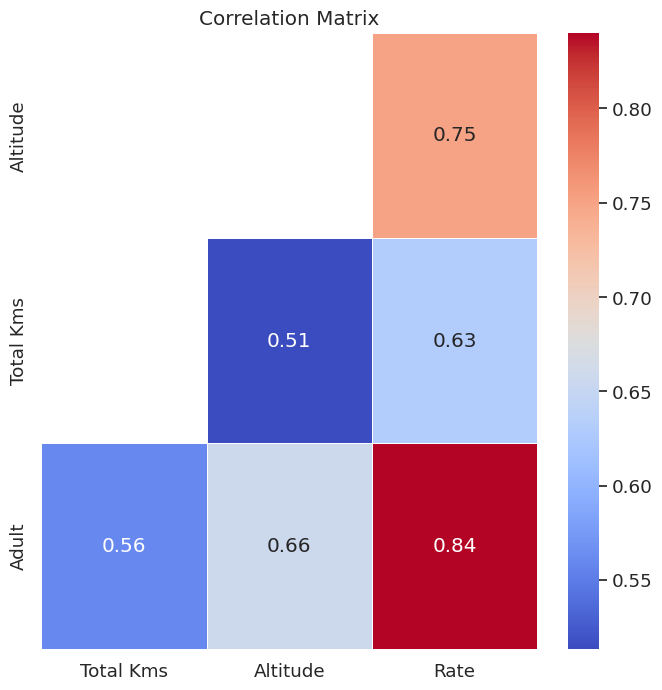

In [42]:
cols = ["Adult", "Total Kms", "Altitude", "Rate"]
cleaned_eus_subset = eus_cleaned[cols]
correlations = cleaned_eus_subset.corr()
correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))
correlations = correlations.drop(["Rate"], axis=0)
correlations = correlations.drop(["Adult"], axis=1)

sns.set(font_scale=1.2)
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5, ax=ax)
ax.set_title("Correlation Matrix")
ax.invert_yaxis()
plt.show()

Below we try two multi-linear regression models, one without interactions, and one with: 

In [43]:
# Perform the multi-linear regression without interactions
model = smf.ols(formula='Adult ~ Altitude + Q("Total Kms") + Rate', data=cleaned_eus_subset).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Adult   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     1144.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        03:57:35   Log-Likelihood:                -4650.9
No. Observations:                1415   AIC:                             9310.
Df Residuals:                    1411   BIC:                             9331.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.2053      0.465      6.

In [44]:
# Perform the multi-linear regression with interactions
model = smf.ols(formula='Adult ~ Altitude*Q("Total Kms")*Rate', data=cleaned_eus_subset).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Adult   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     515.1
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        03:57:36   Log-Likelihood:                -4624.5
No. Observations:                1415   AIC:                             9265.
Df Residuals:                    1407   BIC:                             9307.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

We can see that, for the broad-scope EU data, our model is a decent fit for the data (r-squared above 0.7 for both with and without interactions) - however, we still have some key issues to consider. Both models have strong indicators of multicollinearity, with extremely large condition numbers. The p-values of the predictors for the model without interactions are all statistically significant - however, when interactions are considered, 'Altitude' has a p-value that is not statistically significant. 

Since there are not too many predictors, we can perform best subset selection to find the best combination of predictors and their interactions, to see if any better models might exist out of all possible combinations: 

In [45]:
cleaned_eus_subset = cleaned_eus_subset.rename(columns={"Total Kms": "Total_Kms"})

data = cleaned_eus_subset
# Define predictor variables and response variable
predictors = ['Altitude', 'Total_Kms', 'Rate']
response = 'Adult'

# Generate all combinations of predictor variables (including and excluding interactions)
predictor_combinations = []
for i in range(1, len(predictors) + 1):
    predictor_combinations.extend(list(itertools.combinations(predictors, i)))

# Function to generate interaction terms for a combination of predictors
def generate_interaction_terms(comb):
    interaction_terms = []
    for i in range(1, len(comb) + 1):
        interactions = list(itertools.combinations(comb, i))
        interaction_terms.extend([f"{x[0]}*{x[1]}" for x in interactions if len(x) == 2])
    return interaction_terms

# Generate all combinations of main effects and interaction terms
all_combinations = []
for comb in predictor_combinations:
    for i in range(len(comb) + 1):
        interactions = generate_interaction_terms(comb)
        for interaction_combination in itertools.combinations(interactions, i):
            all_combinations.append(comb + tuple(interaction_combination))

# Add interaction terms to the dataset
for interaction in itertools.combinations(predictors, 2):
    data[f"{interaction[0]}*{interaction[1]}"] = data[interaction[0]] * data[interaction[1]]

# Add three-way interaction term
data["Altitude*Total_Kms*Rate"] = data["Altitude"] * data["Total_Kms"] * data["Rate"]

# Include the three-way interaction term in the list of combinations
all_combinations_with_three_way_interaction = []
for comb in all_combinations:
    all_combinations_with_three_way_interaction.append(comb + ('Altitude*Total_Kms*Rate',))
all_combinations.extend(all_combinations_with_three_way_interaction)

# Perform best subset selection
best_r_squared = 0
best_model = None

for predictor_combination in all_combinations:
    X = data[list(predictor_combination)]
    X = sm.add_constant(X)
    y = data[response]

    model = sm.OLS(y, X).fit()
    r_squared = model.rsquared
    
    # Print r-squared for the current model
    #print(f"Model with predictors {predictor_combination}: R-squared = {r_squared:.5f}")

    if r_squared > best_r_squared:
        best_r_squared = r_squared
        best_model = model

# Print the best model's summary
print("\nBest model:")
print(best_model.summary())



Best model:
                            OLS Regression Results                            
Dep. Variable:                  Adult   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     515.1
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        03:57:37   Log-Likelihood:                -4624.5
No. Observations:                1415   AIC:                             9265.
Df Residuals:                    1407   BIC:                             9307.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const        

The code above shows that the best model in terms of the r-squared value is the one that accounts for all interactions between variables. Unfortunately, the p-value for 'Altitude' is too high to be considered statistically significant for the model. If we consider a model without the 'Altitude' variable: 

In [46]:
model = smf.ols(formula='Adult ~ Total_Kms*Rate', data=cleaned_eus_subset).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Adult   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1137.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        03:57:38   Log-Likelihood:                -4653.9
No. Observations:                1415   AIC:                             9316.
Df Residuals:                    1411   BIC:                             9337.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5388      0.447      7.

Now our p-value terms are problematic for any terms that involve the Total_Kms. 

We can consider without interactions: 

In [47]:
model2 = smf.ols(formula='Adult ~ Total_Kms + Rate', data=cleaned_eus_subset).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Adult   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1706.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        03:57:39   Log-Likelihood:                -4654.3
No. Observations:                1415   AIC:                             9315.
Df Residuals:                    1412   BIC:                             9330.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5595      0.446      7.983      0.0

When we omit altitude and interactions, we find an acceptable model with an only slightly smaller r-squared than was determined via best-subset-selection, and much lessened multicollinearity issues. 

Since we only have two valid predictor variables, we can compare this model with two simplistic linear regressions, one for each predictor variable: 

In [48]:
model = smf.ols(formula='Adult ~ Total_Kms', data=cleaned_eus_subset).fit()

print(model.summary())

model = smf.ols(formula='Adult ~ Rate', data=cleaned_eus_subset).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Adult   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     644.5
Date:                Mon, 08 May 2023   Prob (F-statistic):          1.92e-117
Time:                        03:57:39   Log-Likelihood:                -5257.6
No. Observations:                1415   AIC:                         1.052e+04
Df Residuals:                    1413   BIC:                         1.053e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.2041      0.286     74.016      0.0

Clearly, the model based off the 'Rate' column is superior. These models will be discussed further in the results and analysis section. 

#### Multi-linear Regression and Stepwise Selection: Ratings Data

Unlike the two previous regressions, for the EU ratings data, we have a large number of possible predictors that could possibly be incorporated into our model (16 - refer to the original correlation matrix). We recall the pairs of variables with high correlations and print them here so we may consider how best to edit our data to achieve a better model: 

In [49]:
print(high_correlations) 

                                           Var1  \
18                                     Altitude   
48              Slope offering, variety of runs   
51              Slope offering, variety of runs   
54              Slope offering, variety of runs   
56              Slope offering, variety of runs   
64                         Lifts and cable cars   
67                         Lifts and cable cars   
68                         Lifts and cable cars   
125  Mountain restaurants, ski huts, gastronomy   

                                                  Var2  Correlation  
18                     Slope offering, variety of runs     0.785547  
48                                Lifts and cable cars     0.781761  
51   Orientation (trail map, information boards, si...     0.785073  
54          Mountain restaurants, ski huts, gastronomy     0.759769  
56   Accommodation offering directly at the slopes ...     0.725051  
64   Orientation (trail map, information boards, si...     0.727197  

Lets remove the variables 'Slope offering, variety of runs' and 'Lifts and cable cars' from our model, as well as 'Mountain restaurants, ski huts, gastronomy' (although "Après-ski" activities might not include ratings of ski huts and mountain restaurants that skiers visit while on the slopes and not after, these variables are correlated enough, and it makes sense that, if restaurants at a resort are better overall, the Après-ski rating might be higher), and recalculate the correlation matrix: 

/tmp/ipykernel_641/881959578.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlations_r = correlations_r.mask(np.tril(np.ones(correlations_r.shape)).astype(np.bool))


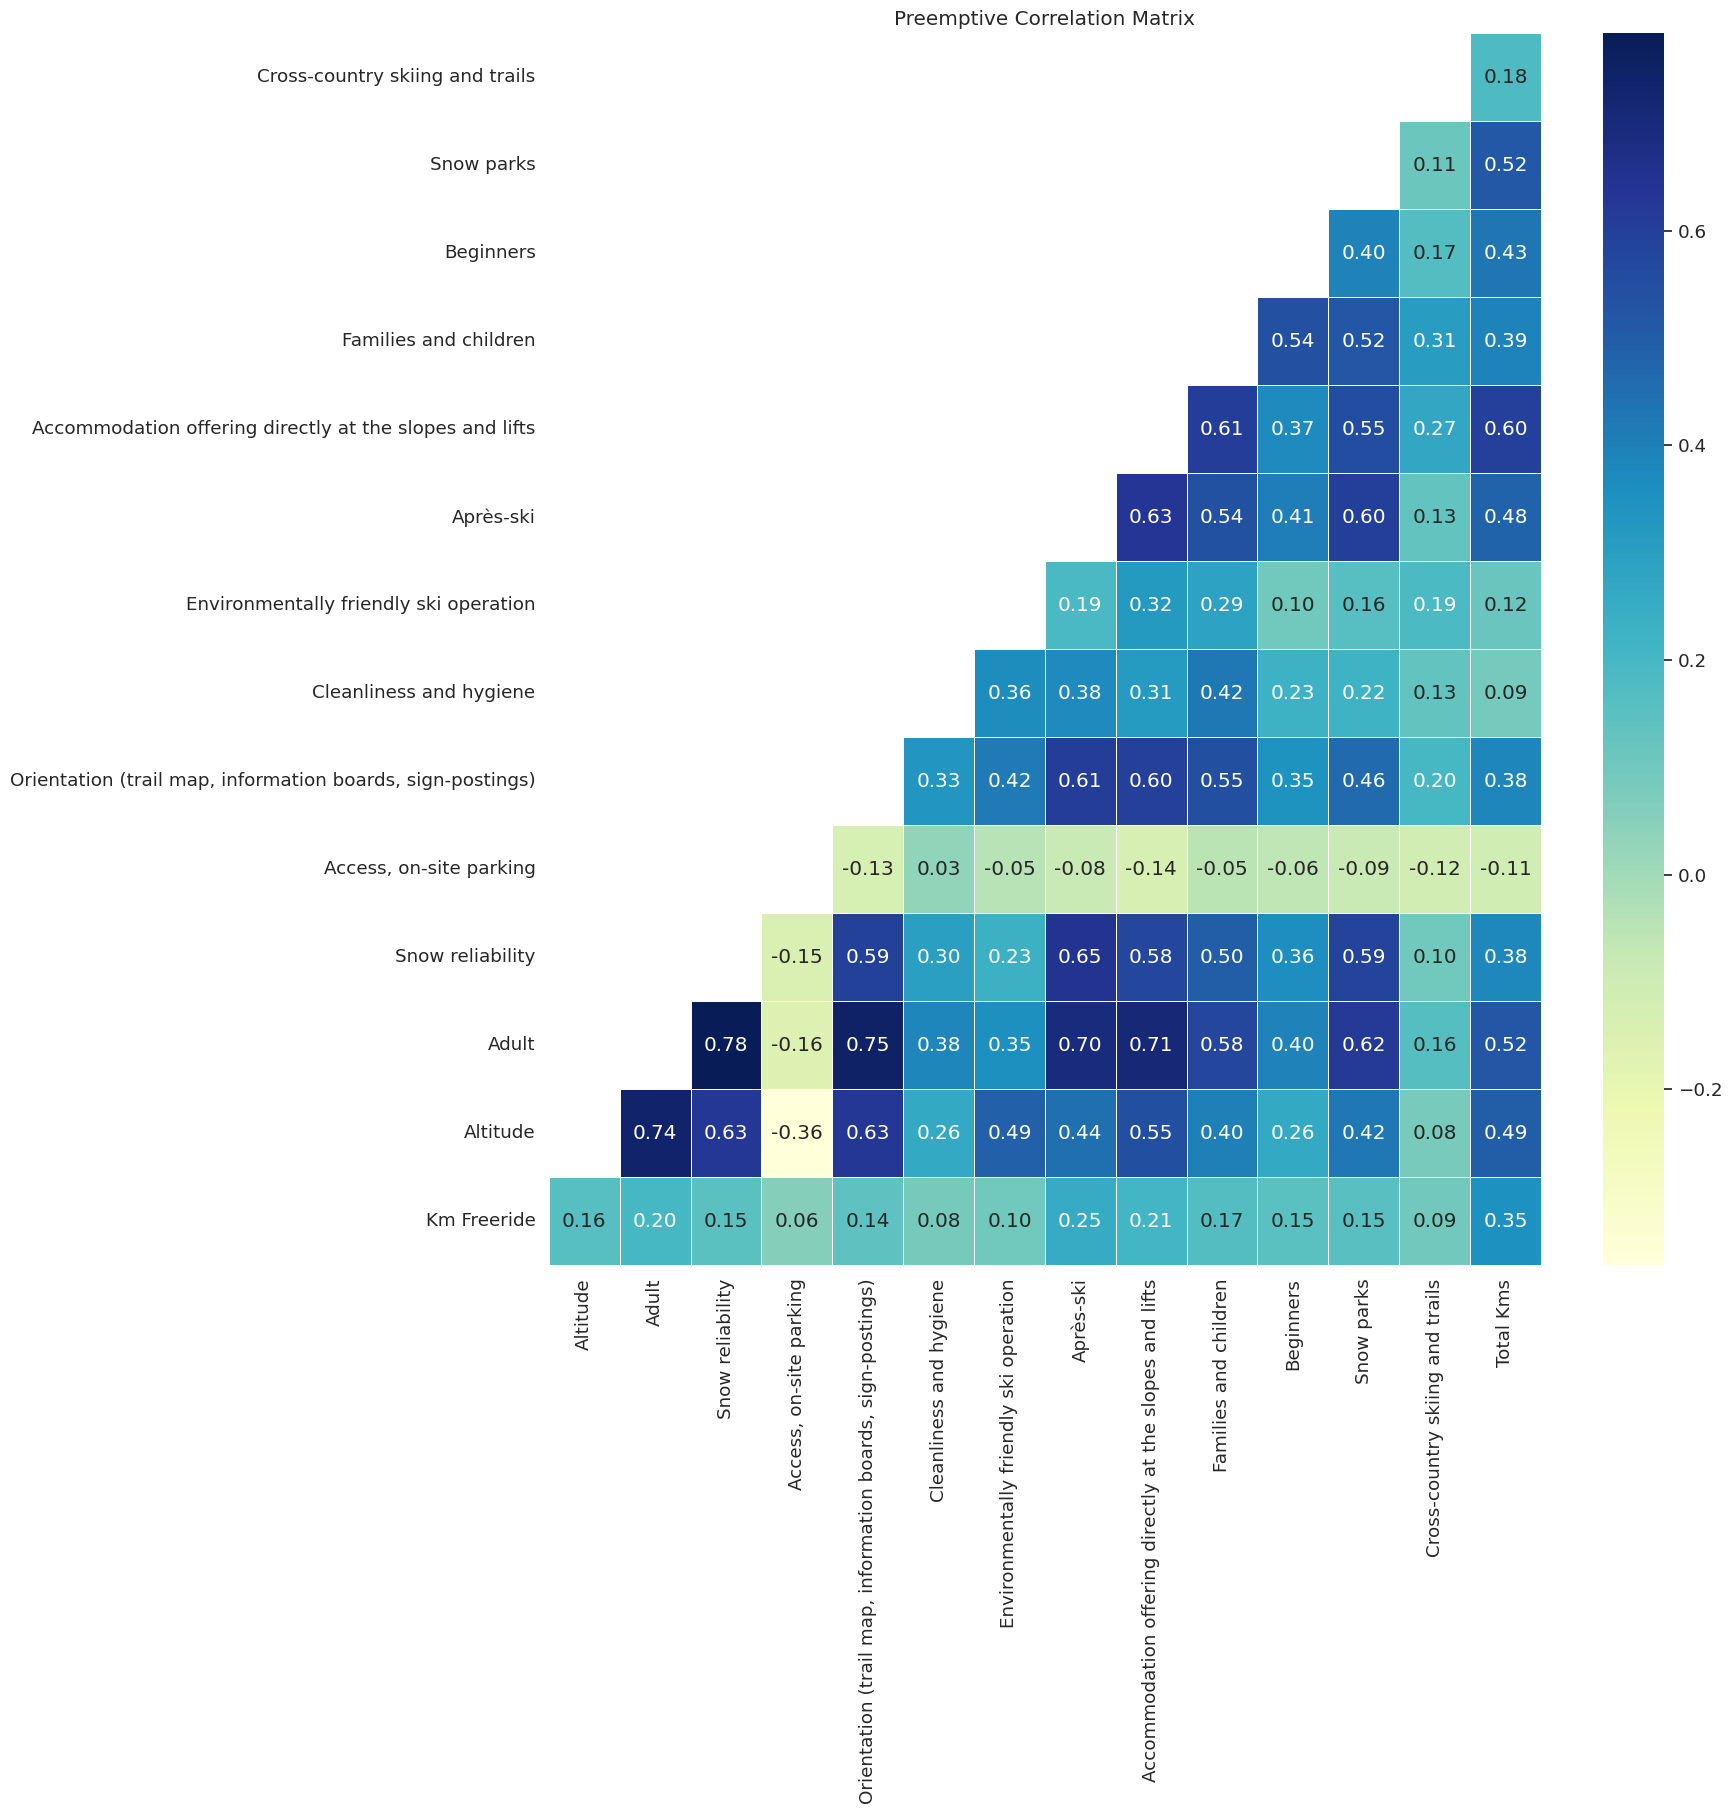

In [50]:
# Drop unwanted columns from the dataset
eus_ratings_filtered = eus_ratings.drop(['Slope offering, variety of runs', 'Lifts and cable cars', 'Mountain restaurants, ski huts, gastronomy'], axis=1)

# Calculate the correlation matrix
correlations_r = eus_ratings_filtered.corr()

# Remove the lower triangle of the correlation matrix
correlations_r = correlations_r.mask(np.tril(np.ones(correlations_r.shape)).astype(np.bool))
correlations_r = correlations_r.drop(["Km Freeride"], axis=1)
correlations_r = correlations_r.drop(["Total Kms"], axis=0)

# Configure seaborn settings
sns.set(font_scale=1.2)
sns.set_style(style='white')

# Create the heatmap
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(correlations_r, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5, ax=ax)
ax.set_title("Preemptive Correlation Matrix")
ax.invert_yaxis()
plt.show()


Since we still have a large number of predictors (13), lets attempt a forward subset selection on the data to fit a model: 

In [51]:
# Assuming eus_ratings_filtered is already defined and 'Adult' is the response variable
X = eus_ratings_filtered.drop('Adult', axis=1)
y = eus_ratings_filtered['Adult']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Perform forward subset selection
selector = SequentialFeatureSelector(model, n_features_to_select=None, direction='forward', cv=5)
selector.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[selector.get_support()]
print("Selected features:")
print(selected_features)

# Fit the linear regression model with the selected features
model.fit(X_train[selected_features], y_train)

# Test the model on the test set
score = model.score(X_test[selected_features], y_test)
print("Model score on test set:", score)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Selected features:
Index(['Altitude', 'Snow reliability',
       'Orientation (trail map, information boards, sign-postings)',
       'Cleanliness and hygiene',
       'Accommodation offering directly at the slopes and lifts', 'Snow parks',
       'Total Kms'],
      dtype='object')
Model score on test set: 0.738094265229693


Let's compare with a backward stepwise selection: 

In [52]:
# Perform backward stepwise selection
selector = SequentialFeatureSelector(model, n_features_to_select=None, direction='backward', cv=5)
selector.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[selector.get_support()]
print("Selected features:")
print(selected_features)

# Fit the linear regression model with the selected features
model.fit(X_train[selected_features], y_train)

# Test the model on the test set
score = model.score(X_test[selected_features], y_test)
print("Model score on test set:", score)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Selected features:
Index(['Altitude', 'Snow reliability',
       'Orientation (trail map, information boards, sign-postings)',
       'Cleanliness and hygiene',
       'Accommodation offering directly at the slopes and lifts', 'Snow parks',
       'Total Kms'],
      dtype='object')
Model score on test set: 0.738094265229693


The forward and backward step selection result in identical models. These will be analyzed and visualized in the "Results and Analysis section". Since we are interested in inference, let us perform a forward stepwise selection with adjusted code, so that the most important factor during each iteration, and the corresponding adjusted r-squared value of the model, is also printed. We will discuss the significance of each feature in the "Results and Analysis" section: 

In [53]:
# Split the dataset into train and test sets
train_data, test_data = train_test_split(eus_ratings_filtered, test_size=0.3, random_state=42)

# List of predictor columns (assuming 'Adult' is the response variable)
allowed_factors = [col for col in eus_ratings_filtered.columns if col != 'Adult']

model = LinearRegression()

selector = SequentialFeatureSelector(model, n_features_to_select=None, direction='forward')

# Fit the selector
X_train = train_data[allowed_factors]
y_train = train_data['Adult']
selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[selector.get_support()]

# Print the R-squared values at each step
for i, feature in enumerate(selected_features):
    selected_predictors = selected_features[:i+1]
    X_train_selected = train_data[selected_predictors]
    y_train_selected = train_data['Adult']
    X_test_selected = test_data[selected_predictors]
    y_test_selected = test_data['Adult']
    
    model.fit(X_train_selected, y_train_selected)
    train_r_squared = model.score(X_train_selected, y_train_selected)
    test_r_squared = model.score(X_test_selected, y_test_selected)
    
    print(f'Selected predictors for k={i+1}: {list(selected_predictors)}, train R-squared={train_r_squared:.4f}, test R-squared={test_r_squared:.4f}')

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Selected predictors for k=1: ['Altitude'], train R-squared=0.5285, test R-squared=0.5867
Selected predictors for k=2: ['Altitude', 'Snow reliability'], train R-squared=0.7382, test R-squared=0.6393
Selected predictors for k=3: ['Altitude', 'Snow reliability', 'Orientation (trail map, information boards, sign-postings)'], train R-squared=0.8035, test R-squared=0.6850
Selected predictors for k=4: ['Altitude', 'Snow reliability', 'Orientation (trail map, information boards, sign-postings)', 'Cleanliness and hygiene'], train R-squared=0.8116, test R-squared=0.6908
Selected predictors for k=5: ['Altitude', 'Snow reliability', 'Orientation (trail map, information boards, sign-postings)', 'Cleanliness and hygiene', 'Accommodation offering directly at the slopes and lifts'], train R-squared=0.8310, test R-squared=0.7234
Selected predictors for k=6: ['Altitude', 'Snow reliability', 'Orientation (trail map, information boards, sign-postings)', 'Cleanliness and hygiene', 'Accommodation offering d

## Results and Analysis

### US Data

#### Model Performance Discussion

Summary of Regression Results:

- Multi-linear Regression Model:
    - R-squared: 0.628
    - Adj. R-squared: 0.626

- Simple Linear Regression Model with Altitude as the predictor:
    - R-squared: 0.284
    - Adj. R-squared: 0.282

- Simple Linear Regression Model with Total Kms as the predictor:
    - R-squared: 0.625
    - Adj. R-squared: 0.624

Comparison of Model Performances:

The multi-linear regression model has an adjusted R-squared of 0.626, the simple linear regression model with altitude as the predictor has an adjusted R-squared of 0.282, and the simple linear regression model with total kilometers as the predictor has an adjusted R-squared of 0.624. The best R-squared comes from the multi-linear regression, but the simple model only factoring in total skiable kilometers has an R-squared that is extremely close. However, neither of these models shows an r-squared value that would be considered very good - at best they are decent at predicting Adult ticket prices (while the simple model to predict prices based on Altitude is objectively poor, with a very low R-squared value. With the data that we had, these were the best-performing models that we could generate, but overall these models do not do a superb job at predicting Adult lift ticket prices in US dollars. Additionally, a key issue is found from the fact that multicollinearity problems are still a concern in the multi-linear model, so even the strongest model we have created does not have very isolated independent variables. The limitations of our conclusions will be discussed further in the "Conclusions" section. 

Visualization: 
Below, we plot the multi-linear regression model line against the data as a way to visualize the model we've generated with pairplots. We can clearly see a linear relationship between Total Kms and the Predicted_Adult ticket, as expected, which shows that this was the most important input to the overall model: 

/tmp/ipykernel_641/910190947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_usdols_subset['Predicted_Adult'] = model1.predict(cleaned_usdols_subset[['Altitude', 'Total Kms']])


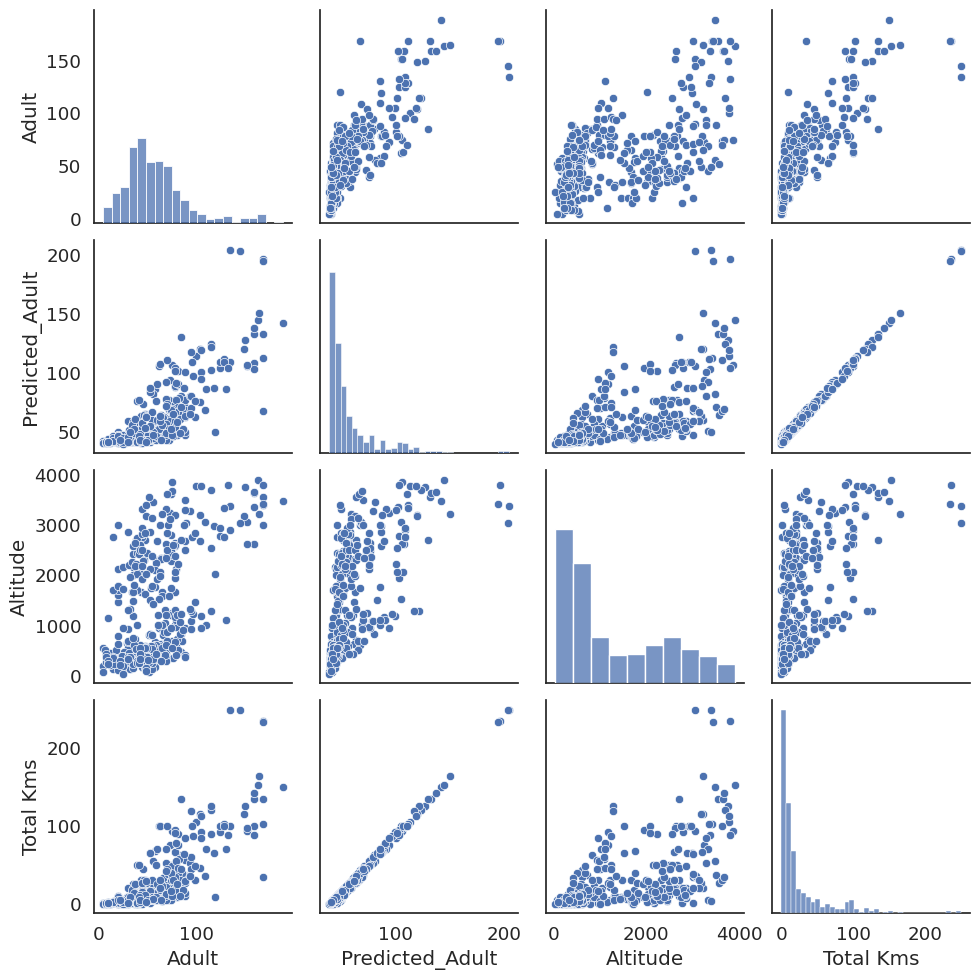

In [54]:
# Create a new column in the dataset with predicted adult lift ticket prices using the multi-linear model
cleaned_usdols_subset['Predicted_Adult'] = model1.predict(cleaned_usdols_subset[['Altitude', 'Total Kms']])

# Create a scatterplot matrix (pair plot) using Seaborn
sns.pairplot(cleaned_usdols_subset, vars=['Adult', 'Predicted_Adult', 'Altitude', 'Total Kms'])
plt.show()


### EU Data 

#### Broad-scope Data Model Performance Discussion

First, let's compare the performance of the three models:

- Multi-linear regression model (Adult ~ Total_Kms + Rate):

    - R-squared: 0.707
    - Adj. R-squared: 0.707
    - F-statistic: 1706
    - AIC: 9315
    - BIC: 9330
- Simple linear regression model (Adult ~ Total_Kms):

    - R-squared: 0.313
    - Adj. R-squared: 0.313
    - F-statistic: 644.5
    - AIC: 1.052e+04
    - BIC: 1.053e+04
- Simple linear regression model (Adult ~ Rate):

    - R-squared: 0.706
    - Adj. R-squared: 0.706
    - F-statistic: 3389
    - AIC: 9320
    - BIC: 9330
    
Model Performance: 

The multi-linear regression model has the highest R-squared and adjusted R-squared values (0.707), indicating that it explains more of the variability in adult lift ticket prices compared to the simple linear regression models (but barely in one case). The model with only the "Rate" variable also has a relatively high R-squared value (0.706), while the model with only the "Total_Kms" variable has a much lower R-squared value (0.313).

Additionally, the multi-linear regression model has the lowest AIC and BIC values, suggesting it is a better fit for the data compared to the other two models. The F-statistic for the multi-linear regression model is also higher than for the simple linear regression models, further supporting its superiority.

Based on these results, it appears that the multi-linear regression model (Adult ~ Total_Kms + Rate) performs best in predicting adult lift ticket prices for EU ski resorts. The "Rate" variable seems to be the most important factor, as it has a much larger coefficient in the multi-linear regression model (9.6763) compared to "Total_Kms" (0.0139).

However, an r-squared value of 0.707 is not a "great" score, and could definitely be improved upon with more viable and complete data. 

Visualization: We generate another pairplot to visualize that the 'Rate' attribute was the most important feature for generating a linear model: 

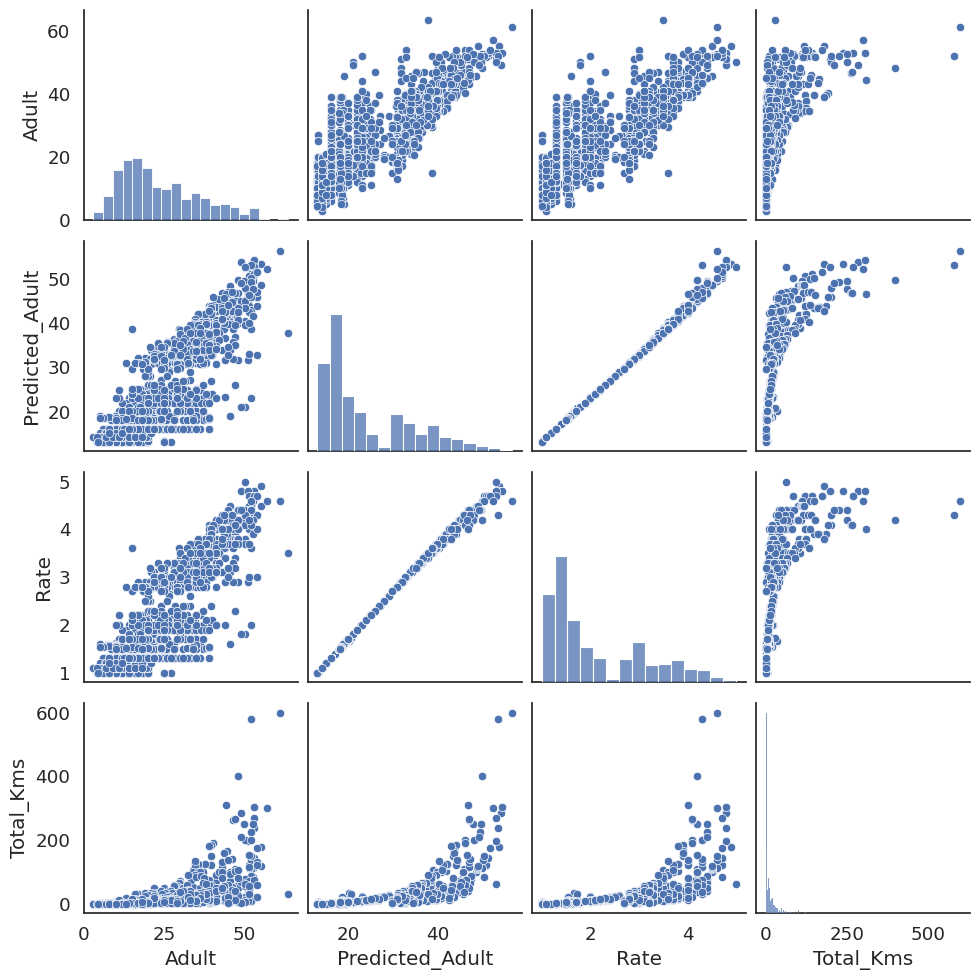

In [55]:
# Create a new column in the dataset with predicted adult lift ticket prices using the multi-linear model
cleaned_eus_subset['Predicted_Adult'] = model2.predict(cleaned_eus_subset[['Rate', 'Total_Kms']])

# Create a scatterplot matrix (pair plot) using Seaborn
sns.pairplot(cleaned_eus_subset, vars=['Adult', 'Predicted_Adult', 'Rate', 'Total_Kms'])
plt.show()

#### EU Specific Feature/Rating Data Model Performance and Discussion

Of all the models we have generated, this provides the most interesting insight towards the most important factors behind EU ski resort price. The only unfortunate aspect of this model is that it was generated from a limited dataset of 284 entries (considering that we had data on over 1000 ski resorts in Europe, this is woefully small). However, this data gave the most accurate metric of any other model we were able to generate (0.738) and gave us the following most critical features for predicting adult lift ticket prices, in order of importance (as detemined by the forward stepwise selection - refer back to the second forward stepwise selection code to see the specific r-squared measurements for each iterative model): 
1. Altitude
2. Snow Reliability
3. Orientation (trail map[s], information boards, sign-postings
4. Cleanliness and hygiene
5. Accommodation offering directly at the slopes and lifts
6. Snow parks
7. Total Kms

Including other metrics did not appear to increase the accuracy of the generated model. 

Though this was the most accurate model by the metric of accuracy by which we measure these separate models, there is still room for imporvement. More analyses should be run when more data is found/made available for more resorts in Europe

## Conclusions

### US Data


Conclusions:

Based on the results, the total kilometers of slopes (Total Kms) appears to be the most important factor in determining adult lift ticket prices for US ski resorts. The multi-linear regression model and the simple linear regression model with Total Kms as the predictor both perform similarly, with adjusted R-squared values of 0.626 and 0.624, respectively. This means that it appears that larger resorts charge more for tickets, which is what we might expect. However, much more data with complete entries for many more factors should be obtained and analyzed before this can be systematically determined. The dataset was unexpectedly sparse and incomplete, and so any conclusions that could be drawn from this analysis should be taken with a grain of salt. This is a somewhat unfortunate and vague conclusion, but it does provide a good jumping off point for further analysis of US ski resort data. 

### Broad-scope EU Data

Conclusions: 
When we compare our results to the US data, we have a somewhat interesting conclusion - the 'Total Kms' column was the most important factor when it came to predicting US lift ticket prices, but compared to the factor of the 'Rate' column upon EU ticket prices, the 'Total Kms' feature is almost insignificant, and 'Altitude' was so detrimental to the model as to not even be included for the final results. We cannot make any conclusions about how the overall rating of a resort as determined by experts factors into US prices (because of lack of data for US resorts) - it might be possible that overall rating is much more important for any ski resort to the ticket price, or it might be possible that Americans pay more for larger resorts, while Europeans care less about resort size when it comes to price and more about other qualities that factor into overall rating.

Our model shows that ski resort experts at skiresort.info decently correlate better quality resorts with higher prices, which is what we might expect and hope for in terms of buying lift tickets, at least in Europe (paying more for a better resort). Overall, however, issues with multicollinearity and missing/incomplete data plagued our analysis throughout this exploration of ski resort data, and thus our level of insight into what truly drives ski resort prices and the conclusions we can draw come up woefully short. Again, any conclusions drawn from a somewhat mediocre predictive model should be taken with a grain of salt. On a more hopeful note, this may provide a benchmark for future analysis into this topic, when better and more complete data can be procured and analyzed. 

### Specific Feature EU Data

This model might be considered contradictory to the broad-scope EU model. The broad scope model could not determine that altitude was a statistically significant predictor of ticket price, while the specific feature data shows altitude to have the most significant role in prediction. Considering that the latter model was determined to be a more accurate predictor of price, and by the fact that it can compare more measurable attributes of ski resorts and their ability to affect ticket price, we consider the list of features selected via forward stepwise selection to be the most important (in order of significance) to determining EU adult lift ticket prices. Below are the features, and some reasons why we speculate they might be the most important features for EU resorts to consider when determining lift ticket prices:

1. Altitude: The altitude of a ski resort is a crucial factor in determining the quality of snow and the length of the skiing season. Higher altitude resorts typically experience colder temperatures, leading to more consistent snowfall and better snow quality. As a result, they can charge higher prices for lift tickets due to the perceived value of better skiing conditions.

2. Snow Reliability: Snow reliability refers to the likelihood of adequate snow coverage throughout the ski season. Resorts with a reputation for reliable snow conditions can demand higher prices because visitors can trust that they'll have good skiing experiences. Additionally, consistent snow coverage means less reliance on artificial snowmaking, which can be expensive and less enjoyable for skiers.

3. Orientation (trail maps, information boards, sign-postings): Proper orientation features are essential for ensuring skiers can easily navigate the resort, find suitable slopes for their skill levels, and access facilities. Well-designed trail maps, clear sign-postings, and informative boards contribute to a smooth and enjoyable skiing experience. Consequently, resorts that invest in these features can justify higher lift ticket prices.

4. Cleanliness and hygiene: In the post-COVID era, cleanliness and hygiene have become critical factors in people's decision-making processes. Ski resorts that maintain high standards of cleanliness in their facilities, including restrooms, dining areas, and rental shops, can attract more visitors and justify higher lift ticket prices (note it is not known if the data on these resorts was collected before or after COVID, so it might be possible that this factor is important to EU skiers regardless of any current pandemics). 

5. Accommodation offerings directly at the slopes and lifts: Resorts with a wide range of lodging options near the slopes and lifts provide convenience and accessibility for guests. This feature allows skiers to maximize their time on the slopes without wasting time on transportation. Consequently, resorts with good accommodation offerings can charge higher prices for lift tickets.

6. Snow parks: Snow parks offer a variety of features, such as jumps, rails, and halfpipes, that cater to freestyle skiers and snowboarders. These parks attract a specific segment of the skiing population, which often values the availability of such facilities. By offering well-maintained and diverse snow parks, resorts can appeal to this audience and charge higher lift ticket prices.

7. Total Kms: The total kilometers of ski slopes available at a resort can significantly influence its appeal. Skiers and snowboarders value the variety and extent of terrain they can explore, which often correlates with the size of the resort. Larger resorts with more kilometers of slopes can provide more diverse skiing experiences, justifying higher lift ticket prices.

